# 05 — d=3 Rotated Surface Code (Surface-17)

- 拓扑图（Surface-17 teaching lattice：data / ancilla / 连接关系）
- 分模块电路：Z 稳定子测量、X 稳定子测量
- **完整一轮** d=3 纠错轮次电路（含所有 stabilizer 的测量）
- 注入单比特 X/Z 错误 → 返回综合征 → toy 解码 → 反馈纠错 → 再测一轮验证
- 过程中**每一步都输出对应电路图**（用于对照理解）

> 说明：本 Notebook 采用的是 Surface-17 patch（9 data + 4 Z-plaquette ancilla + 4 X-boundary ancilla = 17 qubits）

In [1]:
# ---- imports ----
import re
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

## 1. Surface-17 (d=3 rotated patch) 拓扑定义

- data qubit：`d0..d8`（3×3）
- Z stabilizer ancilla：`az0..az3`（**2 个 weight-4 plaquette + 2 个 boundary weight-2**）
- X stabilizer ancilla：`ax0..ax3`（**2 个 weight-4 plaquette + 2 个 boundary weight-2**）

下方 `Z_CHECKS / X_CHECKS` 的 `data` 列表，就是“某个稳定子测量时，会与哪些 data qubit 发生耦合”的拓扑定义。

> 说明：你上传的拓扑图对应 **4 个中心 plaquette（X/Z 交替）+ 4 个边界 stabilizer（左右为 X、上下为 Z）**，总计 8 个稳定子、8 个 ancilla（即 Surface-17）。


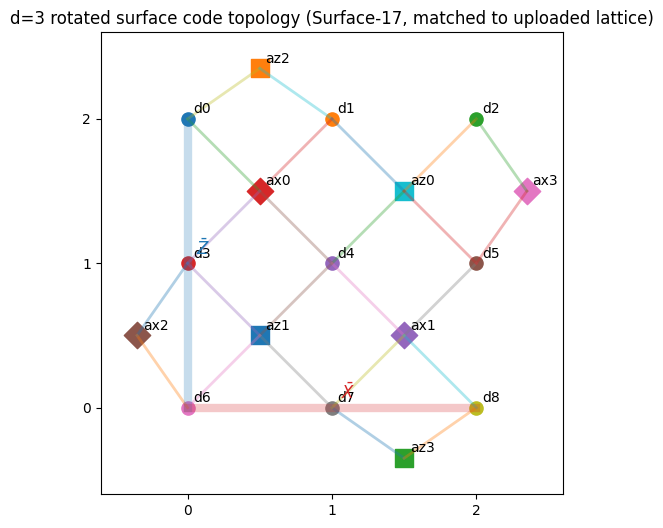

In [2]:
# ---- topology (Surface-17 rotated patch, consistent with uploaded lattice) ----

DATA = [f"d{i}" for i in range(9)]
AZ   = [f"az{i}" for i in range(4)]  # Z-type ancillas (2 plaquette + 2 boundary)
AX   = [f"ax{i}" for i in range(4)]  # X-type ancillas (2 plaquette + 2 boundary)

# data coordinates (for plotting): 3x3 data (d0..d8)
#   d0 d1 d2
#   d3 d4 d5
#   d6 d7 d8
DATA_COORDS = {
    "d0": (0,2), "d1": (1,2), "d2": (2,2),
    "d3": (0,1), "d4": (1,1), "d5": (2,1),
    "d6": (0,0), "d7": (1,0), "d8": (2,0),
}

# In the uploaded topology sketch, the 2x2 interior stabilizers alternate:
#   (top-left)  X   |  (top-right) Z
#   (bot-left)  Z   |  (bot-right) X
# and there are 4 truncated boundary stabilizers:
#   top/bottom are Z-type (weight-2), left/right are X-type (weight-2).

# Z-type stabilizers: 2 weight-4 plaquettes + 2 weight-2 boundaries
Z_CHECKS = [
    {"name":"Zp0", "anc":"az0", "data":["d1","d2","d4","d5"]},  # top-right (weight-4)
    {"name":"Zp1", "anc":"az1", "data":["d3","d4","d6","d7"]},  # bottom-left (weight-4)
    {"name":"ZsT", "anc":"az2", "data":["d0","d1"]},              # top boundary (weight-2)
    {"name":"ZsB", "anc":"az3", "data":["d7","d8"]},              # bottom boundary (weight-2)
]

# X-type stabilizers: 2 weight-4 plaquettes + 2 weight-2 boundaries
X_CHECKS = [
    {"name":"Xp0", "anc":"ax0", "data":["d0","d1","d3","d4"]},  # top-left (weight-4)
    {"name":"Xp1", "anc":"ax1", "data":["d4","d5","d7","d8"]},  # bottom-right (weight-4)
    {"name":"XsL", "anc":"ax2", "data":["d3","d6"]},               # left boundary (weight-2)
    {"name":"XsR", "anc":"ax3", "data":["d2","d5"]},               # right boundary (weight-2)
]

def plot_surface17_topology(show_logicals=True):
    fig, ax = plt.subplots(figsize=(6,6))

    # helper: center of a stabilizer from its incident data qubits
    def center_of(dlist):
        xs, ys = [], []
        for d in dlist:
            x,y = DATA_COORDS[d]
            xs.append(x); ys.append(y)
        return float(np.mean(xs)), float(np.mean(ys))

    # fixed outer positions for boundary stabilizers
    BOUNDARY_POS = {
        "az2": ((DATA_COORDS["d0"][0]+DATA_COORDS["d1"][0])/2, DATA_COORDS["d0"][1]+0.35),  # top Z
        "az3": ((DATA_COORDS["d7"][0]+DATA_COORDS["d8"][0])/2, DATA_COORDS["d7"][1]-0.35),  # bottom Z
        "ax2": (DATA_COORDS["d3"][0]-0.35, (DATA_COORDS["d3"][1]+DATA_COORDS["d6"][1])/2),  # left X
        "ax3": (DATA_COORDS["d2"][0]+0.35, (DATA_COORDS["d2"][1]+DATA_COORDS["d5"][1])/2),  # right X
    }

    # draw data nodes
    for d,(x,y) in DATA_COORDS.items():
        ax.scatter([x],[y], s=90)
        ax.text(x+0.04, y+0.04, d, fontsize=10)

    # draw Z-type stabilizers (squares)
    for stab in Z_CHECKS:
        if len(stab["data"]) == 2:
            cx,cy = BOUNDARY_POS[stab["anc"]]
        else:
            cx,cy = center_of(stab["data"])
        ax.scatter([cx],[cy], marker="s", s=180)
        ax.text(cx+0.04, cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    # draw X-type stabilizers (diamonds)
    for stab in X_CHECKS:
        if len(stab["data"]) == 2:
            cx,cy = BOUNDARY_POS[stab["anc"]]
        else:
            cx,cy = center_of(stab["data"])
        ax.scatter([cx],[cy], marker="D", s=180)
        ax.text(cx+0.04, cy+0.04, stab["anc"], fontsize=10)
        for d in stab["data"]:
            x,y = DATA_COORDS[d]
            ax.plot([cx,x],[cy,y], linewidth=2, alpha=0.35)

    if show_logicals:
        # one valid choice (not unique) for rotated d=3 patch
        logical_Z = ["d0","d3","d6"]
        logical_X = ["d6","d7","d8"]
        def draw_path(qubits, color, label):
            pts = [DATA_COORDS[q] for q in qubits]
            xs = [p[0] for p in pts]
            ys = [p[1] for p in pts]
            ax.plot(xs, ys, linewidth=6, alpha=0.25, color=color)
            ax.text(xs[len(xs)//2]+0.06, ys[len(ys)//2]+0.06, label, fontsize=12, color=color)

        draw_path(logical_Z, "tab:blue", r"$\bar{Z}$")
        draw_path(logical_X, "tab:red",  r"$\bar{X}$")

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-0.6, 2.6)
    ax.set_ylim(-0.6, 2.6)
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_title("d=3 rotated surface code topology (Surface-17, matched to uploaded lattice)")
    plt.show()

plot_surface17_topology(show_logicals=True)



## 2. 命名寄存器（让电路图直接显示 d0/az0/ax0 …）

Qiskit 的 `QuantumCircuit(QuantumRegister(..., name=...))` 会把寄存器名显示在电路左侧。
这里我们把每个 qubit 建成 1-qubit 的寄存器，以得到“和拓扑图一致”的线路标签。

In [3]:
def make_named_qubits():
    qregs = {}
    for d in DATA:
        qregs[d] = QuantumRegister(1, d)
    for a in AZ:
        qregs[a] = QuantumRegister(1, a)
    for a in AX:
        qregs[a] = QuantumRegister(1, a)
    return qregs

def make_named_syndrome_bits():
    # order matters: sZ0..sZ3 then sX0..sX3 (8 bits total)
    cregs = {}
    for i in range(4):
        cregs[f"sZ{i}"] = ClassicalRegister(1, f"sZ{i}")
    for i in range(4):
        cregs[f"sX{i}"] = ClassicalRegister(1, f"sX{i}")
    return cregs

def Q(qregs, name): return qregs[name][0]
def C(cregs, name): return cregs[name][0]

## 3. 稳定子测量模块（Z-check / X-check）

### Z 稳定子测量（检测 X 错误）
- ancilla 初态 |0⟩
- 对每个参与的 data：执行 `CX(data → ancilla)`
- 测量 ancilla（Z 基）得到 0/1：对应稳定子本征值 +1 / -1（教学中用 0/1 表示）

### X 稳定子测量（检测 Z 错误）
- ancilla 先制备 |+⟩：`H`
- 对每个参与的 data：执行 `CX(ancilla → data)`
- 再 `H` 把 X 基测量变为 Z 基测量
- 测量 ancilla 得到 0/1

In [4]:
def measure_Z_check(qc, qregs, anc_name, data_names, cbit, label=None):
    if label:
        qc.barrier(label=label)
    qc.reset(Q(qregs, anc_name))  # safe for multi-round; for single round it's ok too
    for d in data_names:
        qc.cx(Q(qregs, d), Q(qregs, anc_name))
    qc.measure(Q(qregs, anc_name), cbit)

def measure_X_check(qc, qregs, anc_name, data_names, cbit, label=None):
    if label:
        qc.barrier(label=label)
    qc.reset(Q(qregs, anc_name))
    qc.h(Q(qregs, anc_name))
    for d in data_names:
        qc.cx(Q(qregs, anc_name), Q(qregs, d))
    qc.h(Q(qregs, anc_name))
    qc.measure(Q(qregs, anc_name), cbit)

## 4.1 构造“完整一轮” d=3 Surface-17 syndrome 提取电路

这里输出的是**一整轮**：
- 依次测量 4 个 Z stabilizer → 得到 `sZ0..sZ3`
- 再测量 4 个 X stabilizer → 得到 `sX0..sX3`

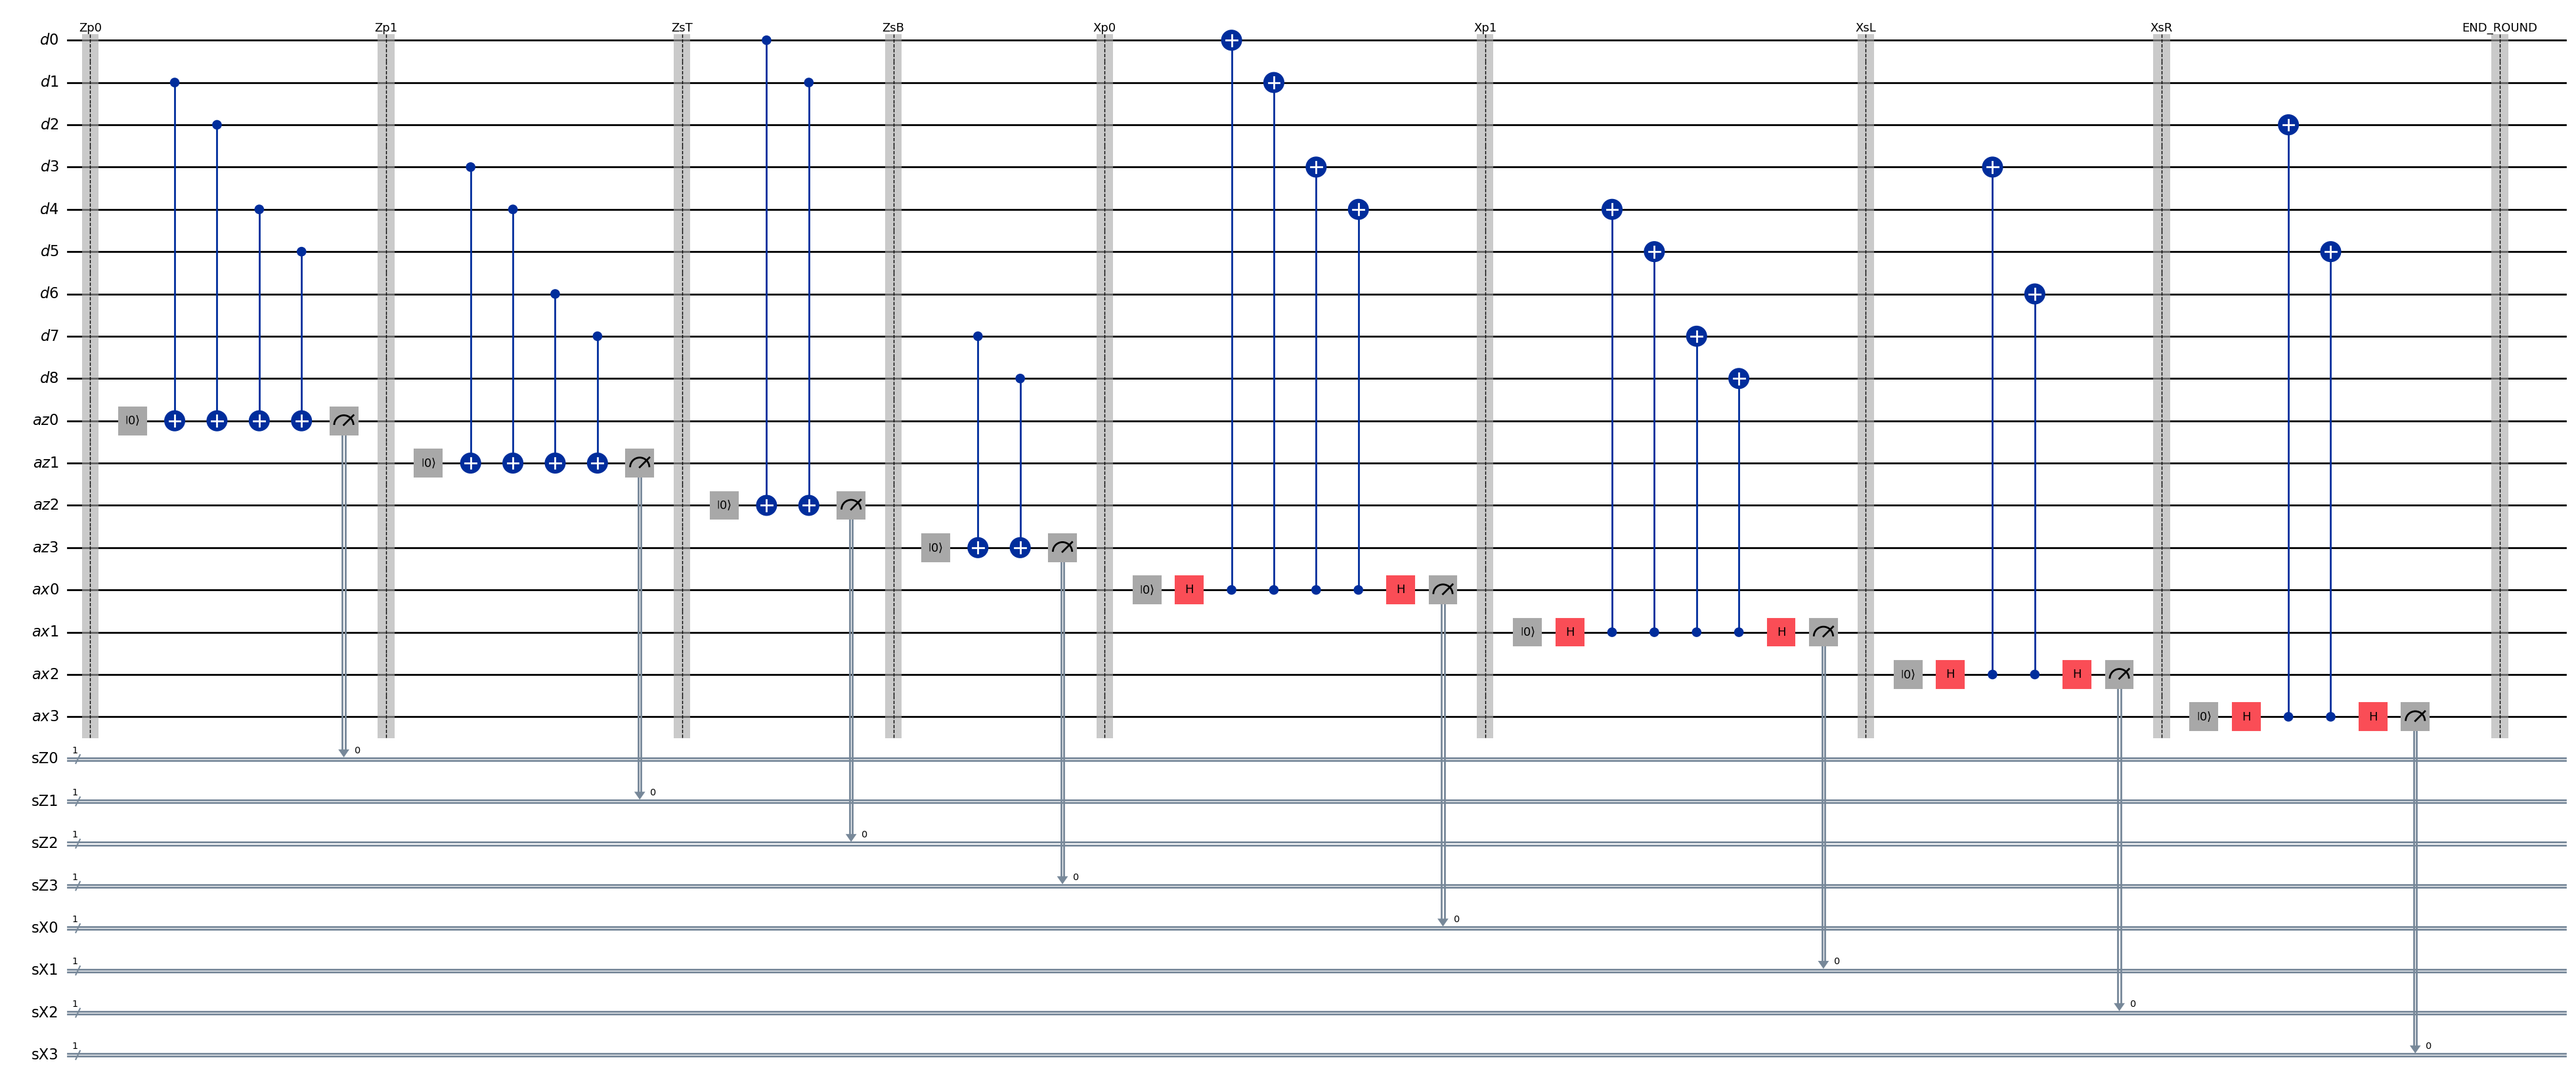

In [5]:
def build_one_round(measure_both=True):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_one_round")

    # Z checks
    for i, stab in enumerate(Z_CHECKS):
        measure_Z_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sZ{i}"), label=stab["name"])

    if measure_both:
        for i, stab in enumerate(X_CHECKS):
            measure_X_check(qc, qregs, stab["anc"], stab["data"], C(cregs, f"sX{i}"), label=stab["name"])

    qc.barrier(label="END_ROUND")
    return qc

qc_round = build_one_round(measure_both=True)
display(qc_round.draw("mpl", fold=-1))

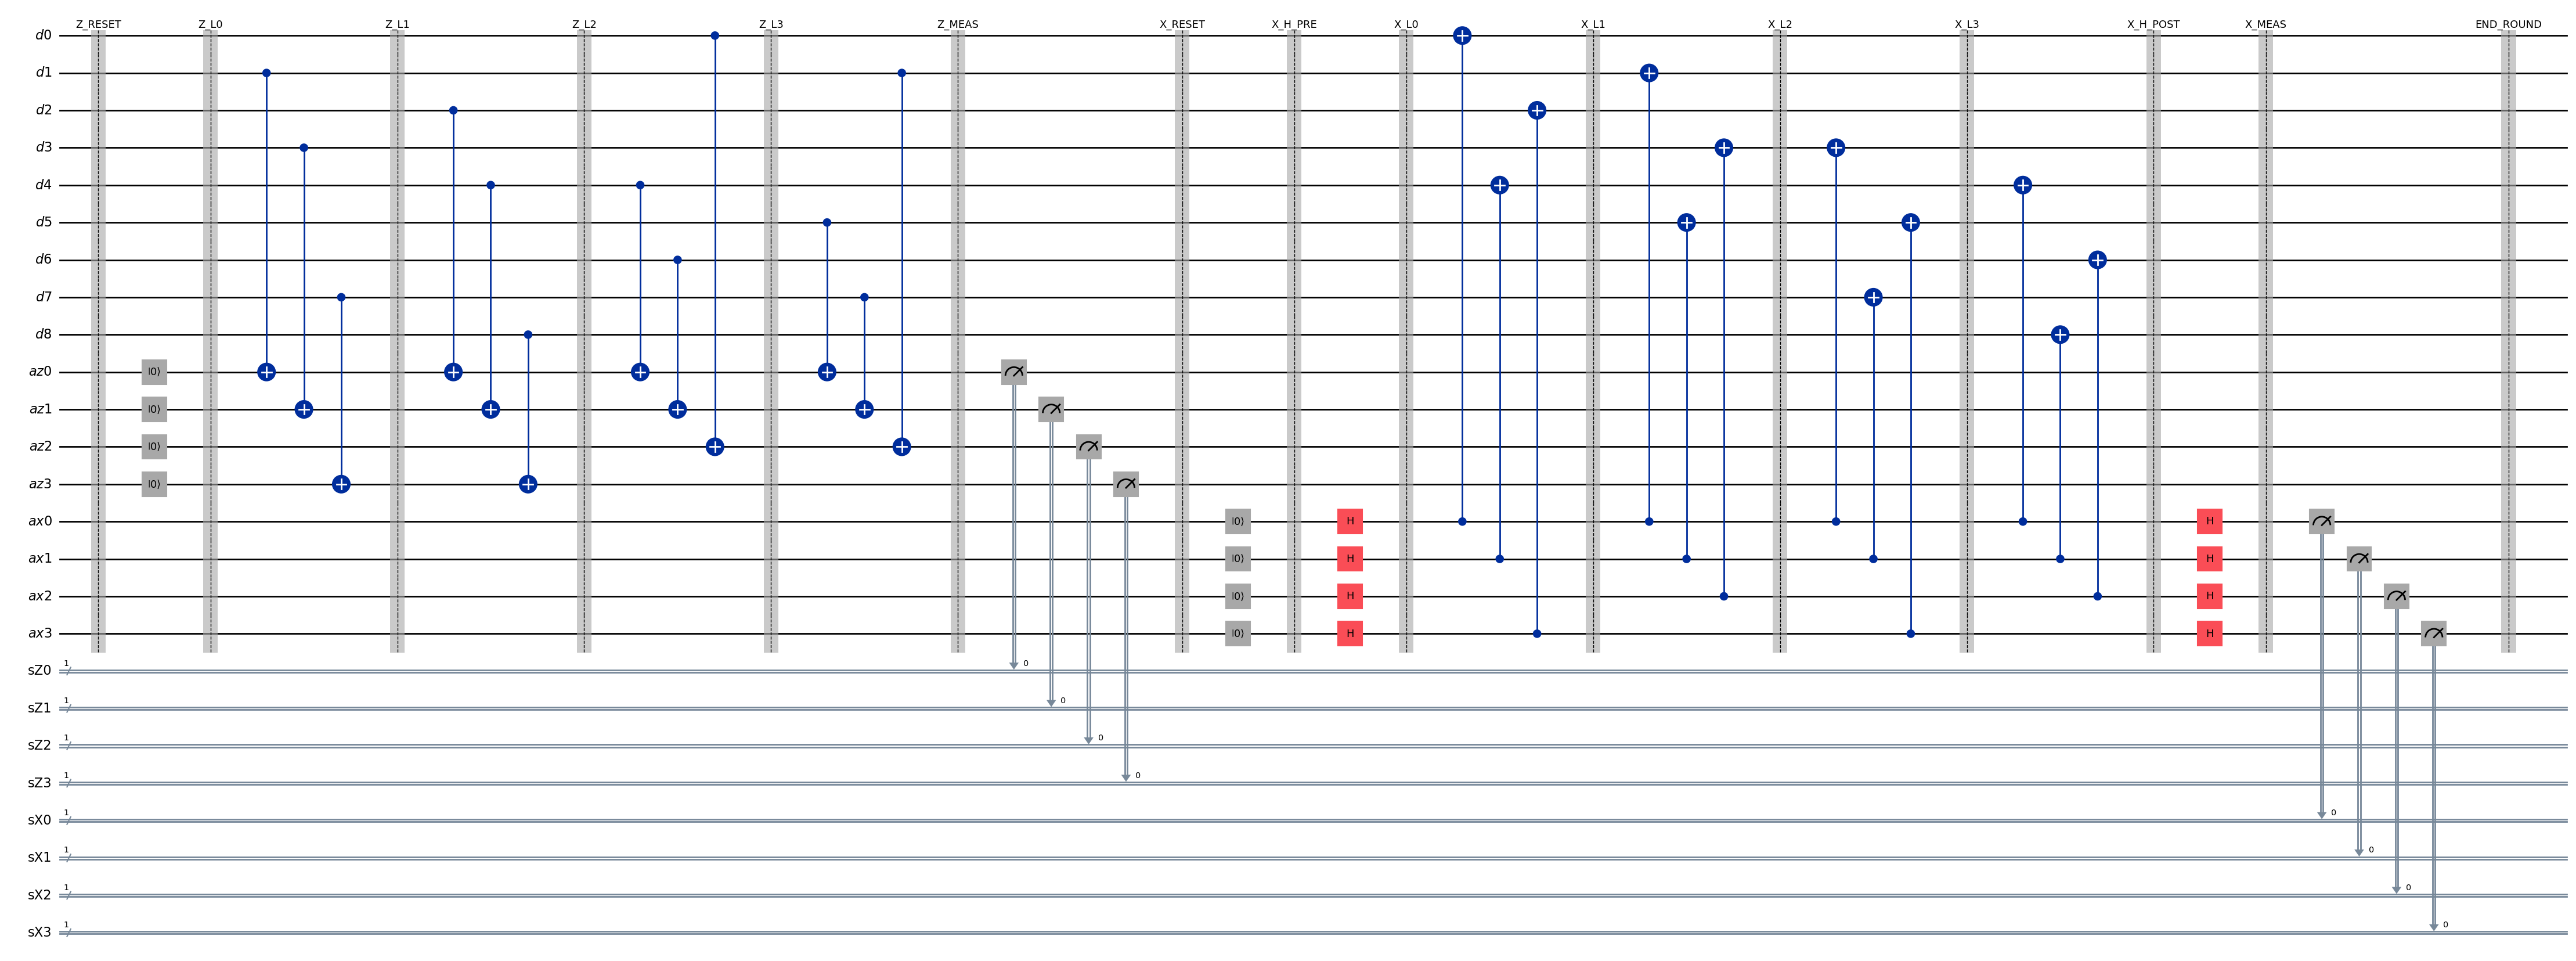

In [30]:
import numpy as np
from qiskit import QuantumCircuit

def _infer_anc_coords():
    """从你已有的拓扑定义推断每个 anc 的几何中心坐标（与 plot_surface17_topology 一致思想）"""
    # interior: 用 data 的中心
    def center_of(dlist):
        xs, ys = [], []
        for d in dlist:
            x, y = DATA_COORDS[d]
            xs.append(x); ys.append(y)
        return (float(np.mean(xs)), float(np.mean(ys)))

    # boundary: 复用你画拓扑时的固定外置位置（不要瞎编）
    BOUNDARY_POS = {
        "az2": ((DATA_COORDS["d0"][0]+DATA_COORDS["d1"][0])/2, DATA_COORDS["d0"][1]+0.35),  # top Z
        "az3": ((DATA_COORDS["d7"][0]+DATA_COORDS["d8"][0])/2, DATA_COORDS["d7"][1]-0.35),  # bottom Z
        "ax2": (DATA_COORDS["d3"][0]-0.35, (DATA_COORDS["d3"][1]+DATA_COORDS["d6"][1])/2),  # left X
        "ax3": (DATA_COORDS["d2"][0]+0.35, (DATA_COORDS["d2"][1]+DATA_COORDS["d5"][1])/2),  # right X
    }

    anc_coords = {}
    for stab in (Z_CHECKS + X_CHECKS):
        anc = stab["anc"]
        if len(stab["data"]) == 2:
            anc_coords[anc] = BOUNDARY_POS[anc]
        else:
            anc_coords[anc] = center_of(stab["data"])
    return anc_coords

def _dir_tag(anc_xy, data_xy):
    """将 data 相对 anc 的方向粗分成 4 类，用于分 layer（并行调度）。"""
    ax, ay = anc_xy
    dx, dy = data_xy
    vx, vy = dx - ax, dy - ay
    sx = 1 if vx > 0 else (-1 if vx < 0 else 0)
    sy = 1 if vy > 0 else (-1 if vy < 0 else 0)
    return (sx, sy)  # (-1,+1)=左上, (+1,+1)=右上, (-1,-1)=左下, (+1,-1)=右下

def _layers_for_checks(checks, anc_coords, dir_order):
    """
    把每个 stabilizer 的 (anc,data) 边按方向分到 4 层。
    返回 layers = [ [(anc,data),...], ... ]，同层可并行。
    """
    # 每个 stabilizer：方向 -> (anc,data)
    stab_edges = []
    for stab in checks:
        anc = stab["anc"]
        axy = anc_coords[anc]
        edges = {}
        for d in stab["data"]:
            tag = _dir_tag(axy, DATA_COORDS[d])
            edges[tag] = (anc, d)
        stab_edges.append(edges)

    layers = []
    for tag in dir_order:
        layer = []
        used = set()
        for edges in stab_edges:
            if tag in edges:
                anc, d = edges[tag]
                # 同层避免 qubit 冲突（真实并行调度必须满足）
                if anc in used or d in used:
                    # 如果这里报错，说明该 tag 顺序不适合你的映射，需要调整 dir_order
                    raise RuntimeError(f"Layer conflict for tag={tag} edge=({anc},{d})")
                layer.append((anc, d))
                used.add(anc); used.add(d)
        layers.append(layer)
    return layers

def build_one_round_hw(measure_both=True):
    """
    真实测控/实验常用的“分层并行”时序：
      Z: reset(all az) -> 4 layers CX(data→az) -> measure(all az)
      X: reset(all ax) -> H(all ax) -> 4 layers CX(ax→data) -> H(all ax) -> measure(all ax)
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_one_round_HW")

    anc_coords = _infer_anc_coords()

    # 你可以调这个方向顺序来匹配你们实际“蛇形/避免串扰”的硬件策略
    DIR_ORDER = [(-1, +1), (+1, +1), (-1, -1), (+1, -1)]

    # ---------- Z checks (sZ0..sZ3 对应 Z_CHECKS 顺序不变) ----------
    qc.barrier(label="Z_RESET")
    for stab in Z_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    z_layers = _layers_for_checks(Z_CHECKS, anc_coords, DIR_ORDER)
    for li, layer in enumerate(z_layers):
        qc.barrier(label=f"Z_L{li}")
        for anc, d in layer:
            qc.cx(Q(qregs, d), Q(qregs, anc))  # data -> anc

    qc.barrier(label="Z_MEAS")
    for i, stab in enumerate(Z_CHECKS):
        qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sZ{i}"))

    if not measure_both:
        qc.barrier(label="END_ROUND")
        return qc

    # ---------- X checks (sX0..sX3 对应 X_CHECKS 顺序不变) ----------
    qc.barrier(label="X_RESET")
    for stab in X_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    qc.barrier(label="X_H_PRE")
    for stab in X_CHECKS:
        qc.h(Q(qregs, stab["anc"]))

    x_layers = _layers_for_checks(X_CHECKS, anc_coords, DIR_ORDER)
    for li, layer in enumerate(x_layers):
        qc.barrier(label=f"X_L{li}")
        for anc, d in layer:
            qc.cx(Q(qregs, anc), Q(qregs, d))  # anc -> data

    qc.barrier(label="X_H_POST")
    for stab in X_CHECKS:
        qc.h(Q(qregs, stab["anc"]))

    qc.barrier(label="X_MEAS")
    for i, stab in enumerate(X_CHECKS):
        qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sX{i}"))

    qc.barrier(label="END_ROUND")
    return qc

# 画“真实测控顺序”的单张时序电路图
qc_hw = build_one_round_hw(measure_both=True)
display(qc_hw.draw("mpl", fold=-1))


C:\Users\admin\AppData\Local\Temp\ipykernel_11680\235182070.py:11: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


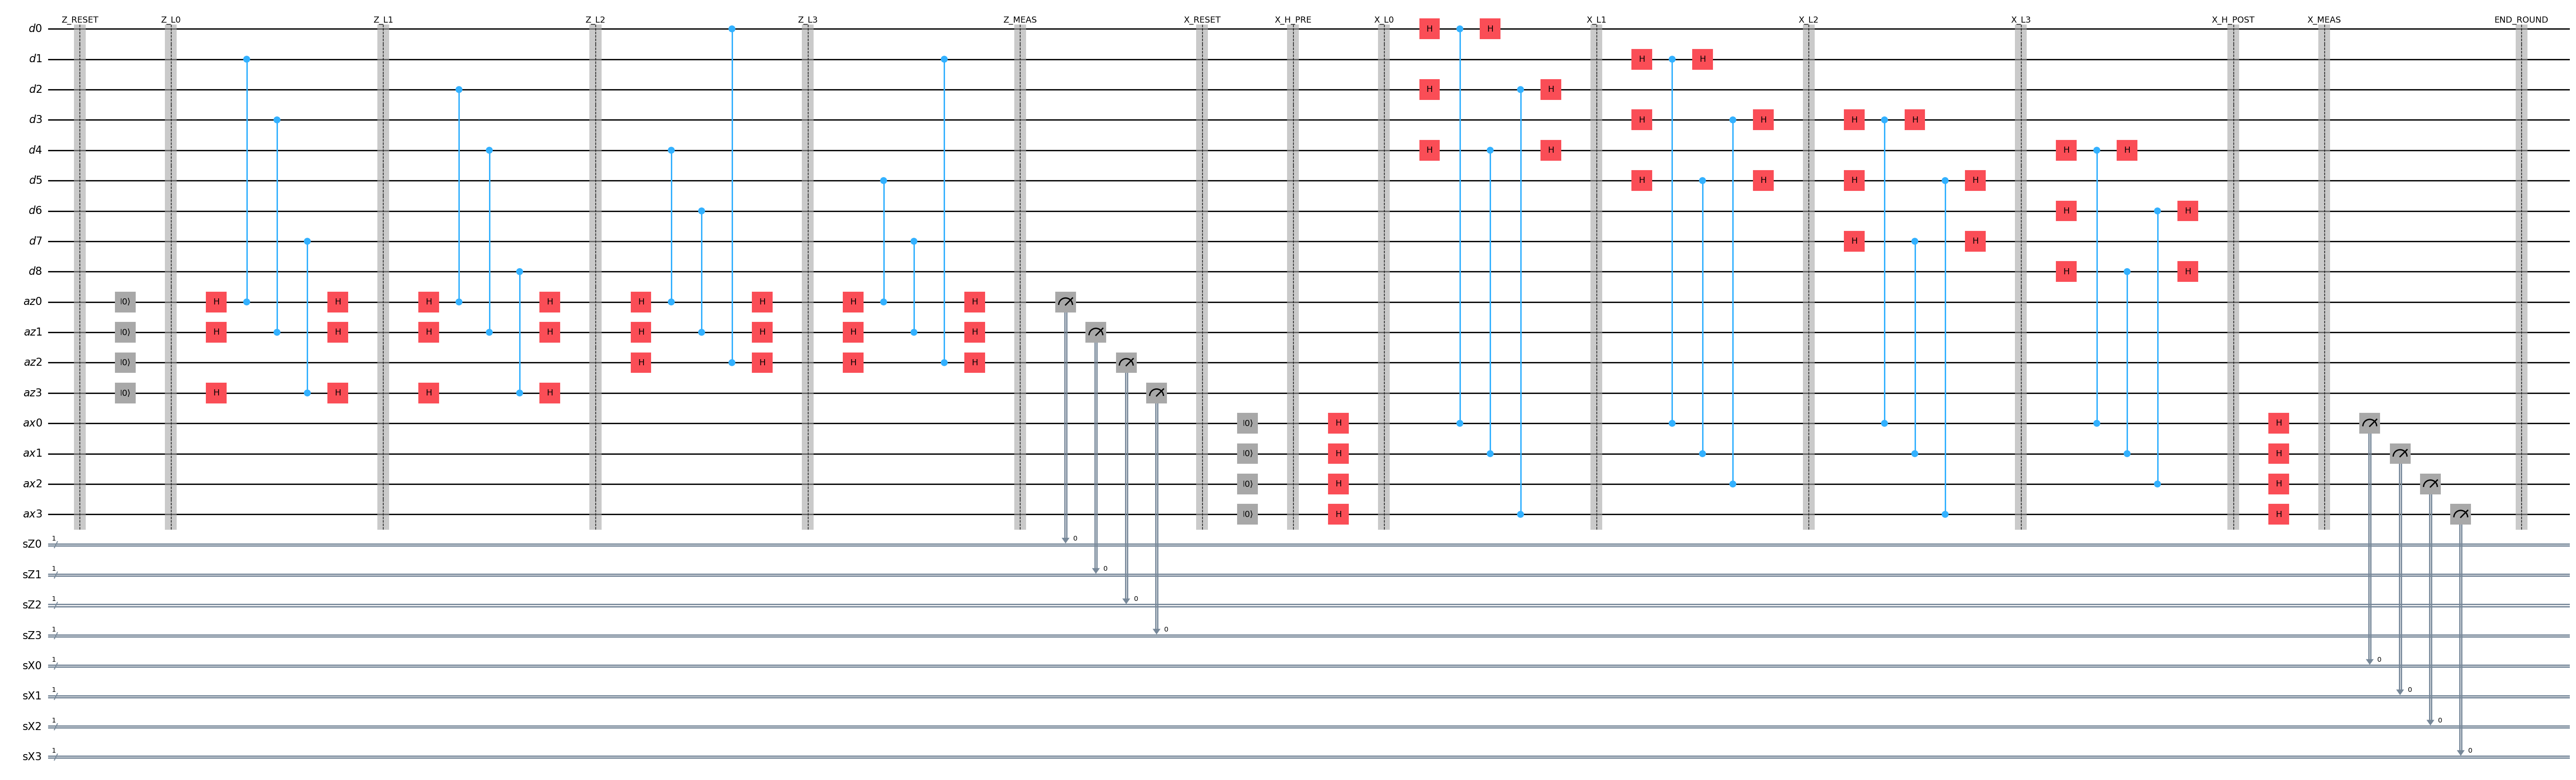

In [35]:
from qiskit import QuantumCircuit

def compile_cx_to_h_cz_keep_barriers(qc: QuantumCircuit) -> QuantumCircuit:
    """
    将电路中的所有 CX 编译为 H(target) - CZ - H(target)。
    - 保留 barrier（你的全局分层标签仍然可见）
    - 保留 reset/measure 等指令原样
    - 不调用 transpile（避免改变你手工/自定义调度后的时序结构）
    """
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_HCZ")
    for inst, qargs, cargs in qc.data:
        if inst.name in ("cx", "cnot"):
            ctrl, tgt = qargs[0], qargs[1]
            out.h(tgt)
            out.cz(ctrl, tgt)
            out.h(tgt)
        else:
            out.append(inst, qargs, cargs)
    return out

# 用法：qc_hw_global 是你截图里这个“global layered mixed”电路
qc_hcz = compile_cx_to_h_cz_keep_barriers(qc_hw)

display(qc_hcz.draw("mpl", fold=-1))

C:\Users\admin\AppData\Local\Temp\ipykernel_11680\329049386.py:22: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:
C:\Users\admin\AppData\Local\Temp\ipykernel_11680\329049386.py:12: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for j, (inst2, q2, c2) in enumerate(out.data):


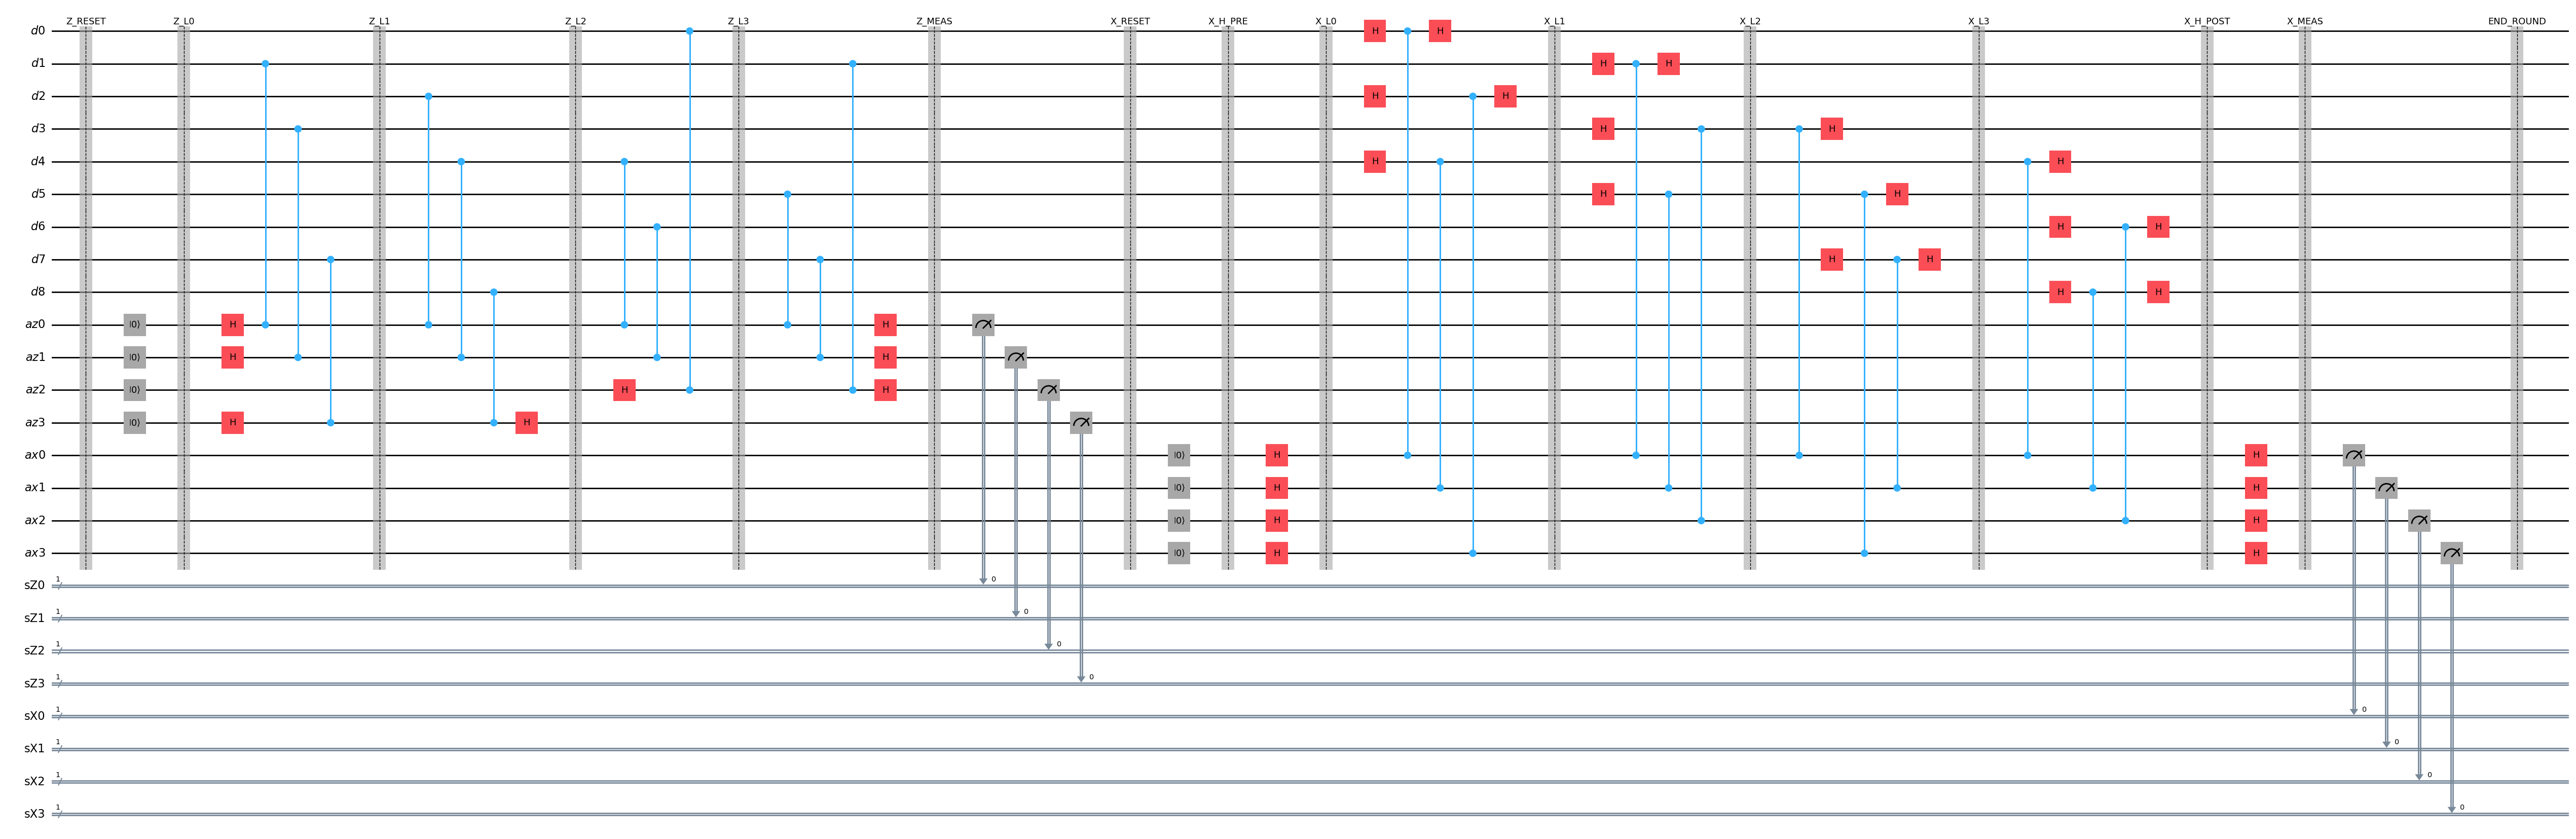

In [37]:
def cancel_H_pairs_allow_across_barrier(qc: QuantumCircuit) -> QuantumCircuit:
    """
    消去同一比特线上可抵消的 H-H（H·H=I）。
    - barrier 不打断（允许跨 barrier 合并 H）
    - 其他门（cz/reset/measure等）仍然打断
    """
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_Hcancel_nobarrierbreak")
    last_H_idx = {}

    def rebuild_last_H_idx():
        last_H_idx.clear()
        for j, (inst2, q2, c2) in enumerate(out.data):
            if inst2.name == "h":
                last_H_idx[q2[0]] = j
            elif inst2.name == "barrier":
                # 不打断
                pass
            else:
                for qq in q2:
                    last_H_idx.pop(qq, None)

    for inst, qargs, cargs in qc.data:
        if inst.name == "h":
            q = qargs[0]
            if q in last_H_idx:
                out.data.pop(last_H_idx[q])
                rebuild_last_H_idx()
            else:
                out.h(q)
                last_H_idx[q] = len(out.data) - 1
            continue

        out.append(inst, qargs, cargs)

        if inst.name != "barrier":
            for q in qargs:
                last_H_idx.pop(q, None)

    return out
    """
    消去同一比特线上可抵消的 H-H（H·H=I）。
    - 任何作用到该qubit的操作都会“打断”可合并性，包括 barrier
    - 不调用 transpile，不重排 CZ 等门
    """
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_Hcancel")

    # 记录每个 qubit 上最近一个“未匹配”的 H 在 out.data 中的位置
    last_H_idx = {}

    def rebuild_last_H_idx():
        """当 out.data 被 pop 后索引可能失效，重建 last_H_idx（规模小，直接重建最稳妥）"""
        last_H_idx.clear()
        for j, (inst2, q2, c2) in enumerate(out.data):
            if inst2.name == "h":
                last_H_idx[q2[0]] = j
            else:
                # 任何非H门都打断其作用比特的 pending-H
                for qq in q2:
                    last_H_idx.pop(qq, None)

    for inst, qargs, cargs in qc.data:
        if inst.name == "h":
            q = qargs[0]
            if q in last_H_idx:
                # 抵消：删除之前那个H，不再追加当前H
                out.data.pop(last_H_idx[q])
                rebuild_last_H_idx()
            else:
                out.h(q)
                last_H_idx[q] = len(out.data) - 1
            continue

        # 其他指令原样写入
        out.append(inst, qargs, cargs)

        # 该指令作用到的所有 qubit 都会打断 pending-H
        for q in qargs:
            last_H_idx.pop(q, None)

        # barrier 也会打断所有参与 qubit 的 pending-H（qargs 已覆盖）
        # measure/reset/cz 等同理

    return out

qc_hcz_opt = cancel_H_pairs_allow_across_barrier(qc_hcz)
display(qc_hcz_opt.draw("mpl", fold=-1))

## 4.2 按照时序顺序运行的电路图
Z_RESET → Z_L0 → Z_L1 → Z_L2 → Z_L3 → Z_MEAS → X_RESET → X_H_PRE → X_L0… → X_MEAS → END_ROUND

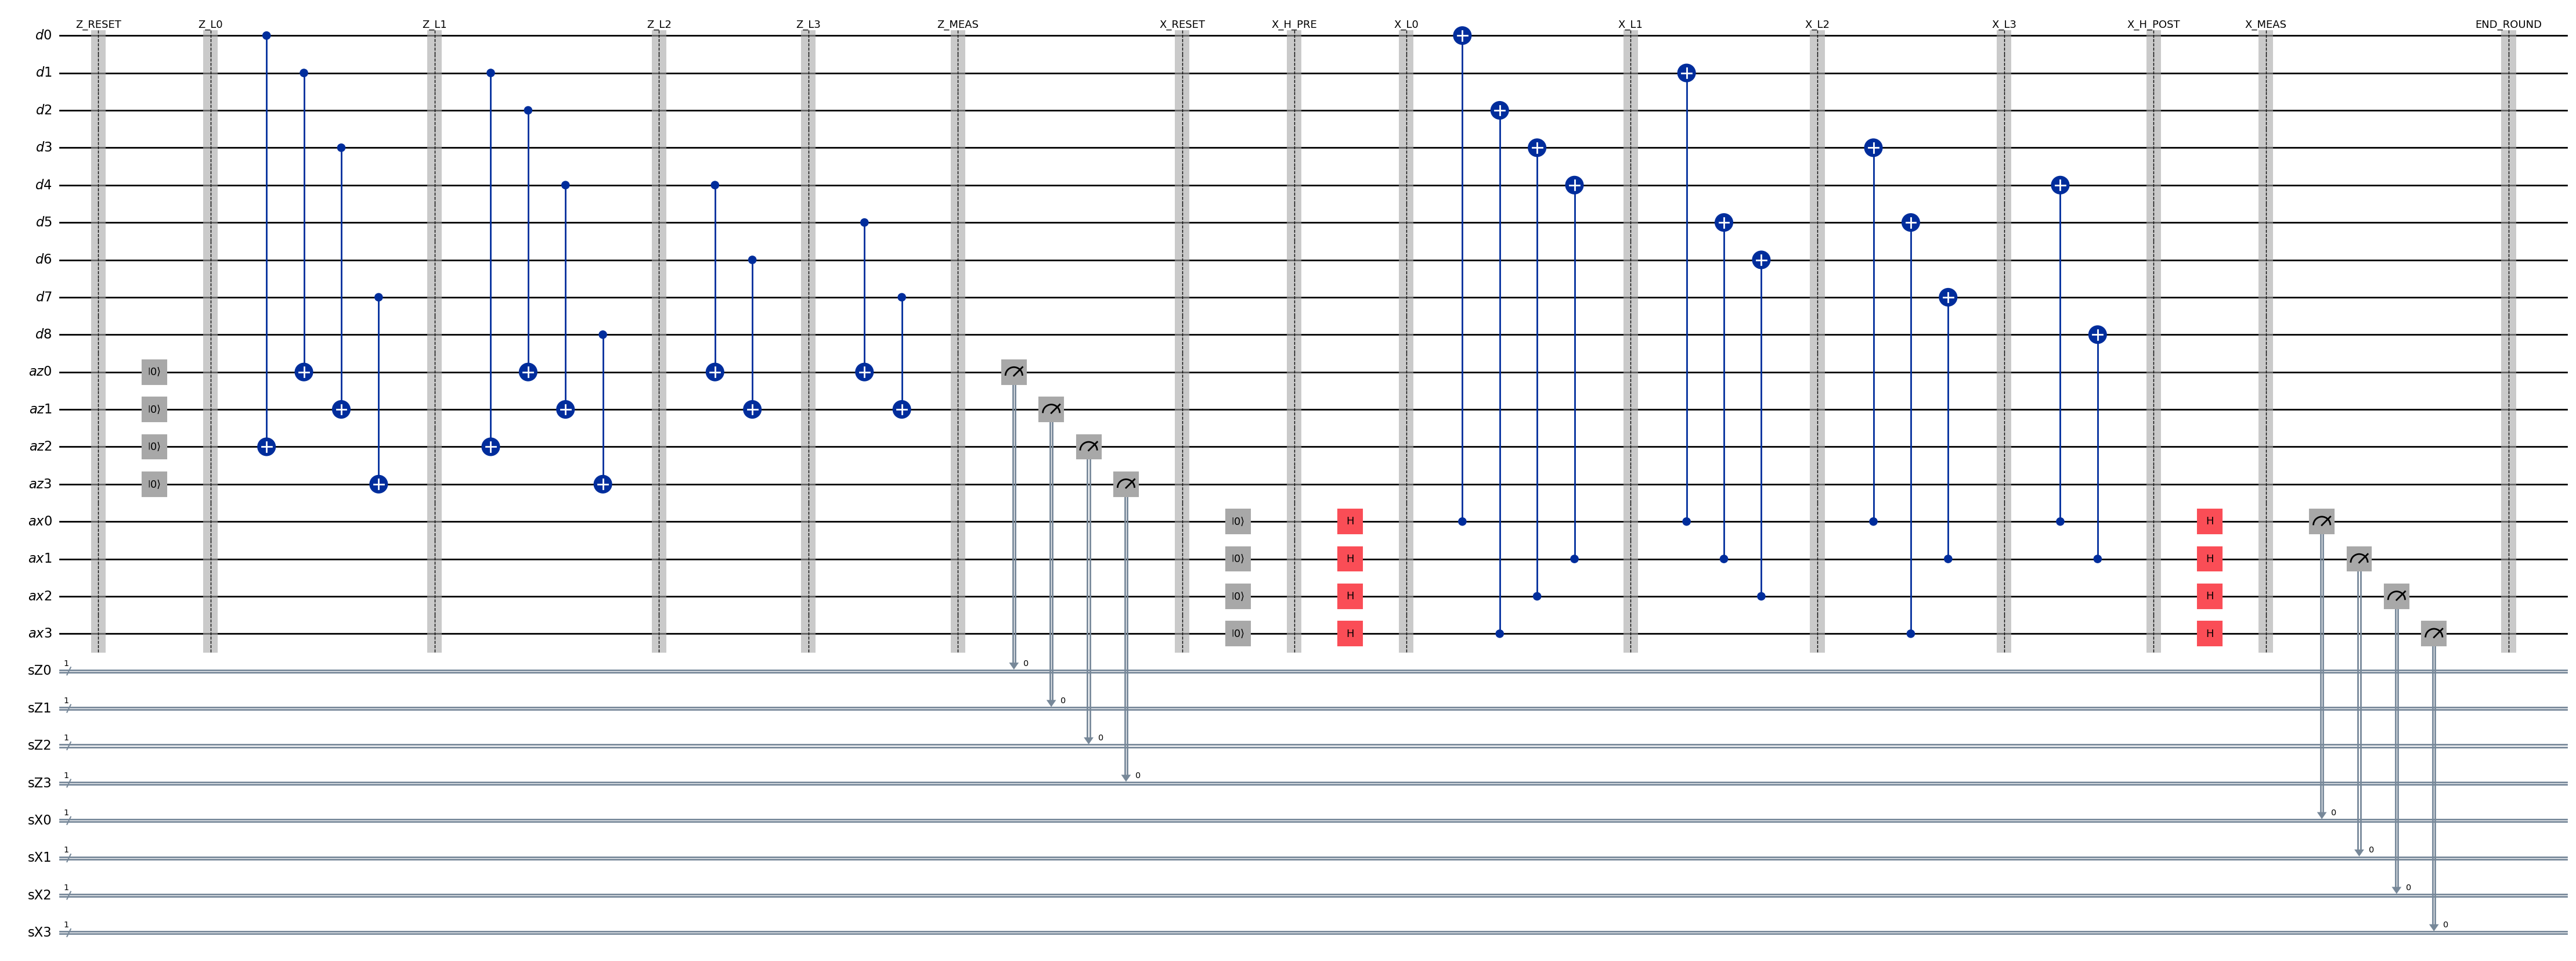

In [ ]:
from collections import defaultdict, deque

def _edges_for_checks_data_anc(checks):
    """
    从 checks 生成所有需要执行的边（data, anc）
    例如 Z_CHECKS: data -> az*
    X_CHECKS: ax* -> data 但这里统一返回 (data, anc)
    """
    edges = []
    for stab in checks:
        anc = stab["anc"]
        for d in stab["data"]:
            edges.append((d, anc))
    return edges
def _schedule_layers_by_data(edges, data_order):
    """
    edges: list[(data, anc)]  本轮所有需要执行的两比特边
    data_order: list[str]     每层按这个 data 顺序尝试放边（决定“像你例子那样”一层塞很多）

    返回 layers: list[list[(data, anc)]]
      - 同一层中：data 不重复（我们按 data_order 扫描天然不重复）
      - 同一层中：anc 不重复（显式检查）
    """
    # data -> anc queue（一个 data 可能要连 1~2 个 anc）
    adj = defaultdict(deque)
    for d, a in edges:
        adj[d].append(a)

    remaining = sum(len(adj[d]) for d in adj)

    layers = []
    while remaining > 0:
        used_anc = set()
        layer = []

        # 这一层：每个 data 最多取一条边（更符合“按数据并行”的硬件直觉）
        for d in data_order:
            if not adj[d]:
                continue

            # 从该 data 的候选 anc 里，找一个本层没占用的 anc
            chosen_idx = None
            for i, a in enumerate(adj[d]):
                if a not in used_anc:
                    chosen_idx = i
                    break

            if chosen_idx is None:
                continue  # 这一层该 data 暂时放不下（因为 anc 冲突），留到下一层

            # 取出 chosen anc
            a = adj[d][chosen_idx]
            # deque 不支持 pop(i)，这里用 rotate 技巧或转 list；规模很小，直接转 list 最简单
            tmp = list(adj[d])
            tmp.pop(chosen_idx)
            adj[d] = deque(tmp)

            layer.append((d, a))
            used_anc.add(a)
            remaining -= 1

        if not layer:
            # 理论上不应该发生；发生说明 data_order 或边集异常导致无法推进
            raise RuntimeError("Scheduling stalled: no edge can be placed in a new layer. Check edge set / data_order.")

        layers.append(layer)

    return layers
def build_one_round_hw_data_scheduled(measure_both=True):
    """
    数据比特驱动的最大并行调度：
      Z: reset(all az) -> layers of CX(data→az) -> measure(all az)
      X: reset(all ax) -> H(all ax) -> layers of CX(ax→data) -> H(all ax) -> measure(all ax)
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_one_round_HW_DATA")

    # 你也可以自定义 data 的扫描顺序；这里按 d0..d8
    DATA_ORDER = [f"d{i}" for i in range(9)]

    # -------------------- Z checks --------------------
    qc.barrier(label="Z_RESET")
    for stab in Z_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    # Z 的边： (data, anc)
    z_edges = _edges_for_checks_data_anc(Z_CHECKS)
    z_layers = _schedule_layers_by_data(z_edges, DATA_ORDER)

    for li, layer in enumerate(z_layers):
        qc.barrier(label=f"Z_L{li}")
        for d, anc in layer:
            qc.cx(Q(qregs, d), Q(qregs, anc))  # data -> anc

    qc.barrier(label="Z_MEAS")
    for i, stab in enumerate(Z_CHECKS):
        qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sZ{i}"))

    if not measure_both:
        qc.barrier(label="END_ROUND")
        return qc

    # -------------------- X checks --------------------
    qc.barrier(label="X_RESET")
    for stab in X_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    qc.barrier(label="X_H_PRE")
    for stab in X_CHECKS:
        qc.h(Q(qregs, stab["anc"]))

    # X 的边：统一用 (data, anc) 来调度，但落门时是 anc->data
    x_edges = _edges_for_checks_data_anc(X_CHECKS)  # (data, ax*)
    x_layers = _schedule_layers_by_data(x_edges, DATA_ORDER)

    for li, layer in enumerate(x_layers):
        qc.barrier(label=f"X_L{li}")
        for d, anc in layer:
            qc.cx(Q(qregs, anc), Q(qregs, d))  # anc -> data

    qc.barrier(label="X_H_POST")
    for stab in X_CHECKS:
        qc.h(Q(qregs, stab["anc"]))

    qc.barrier(label="X_MEAS")
    for i, stab in enumerate(X_CHECKS):
        qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sX{i}"))

    qc.barrier(label="END_ROUND")
    return qc
qc_hw = build_one_round_hw_data_scheduled(measure_both=True)
display(qc_hw.draw("mpl", fold=-1))


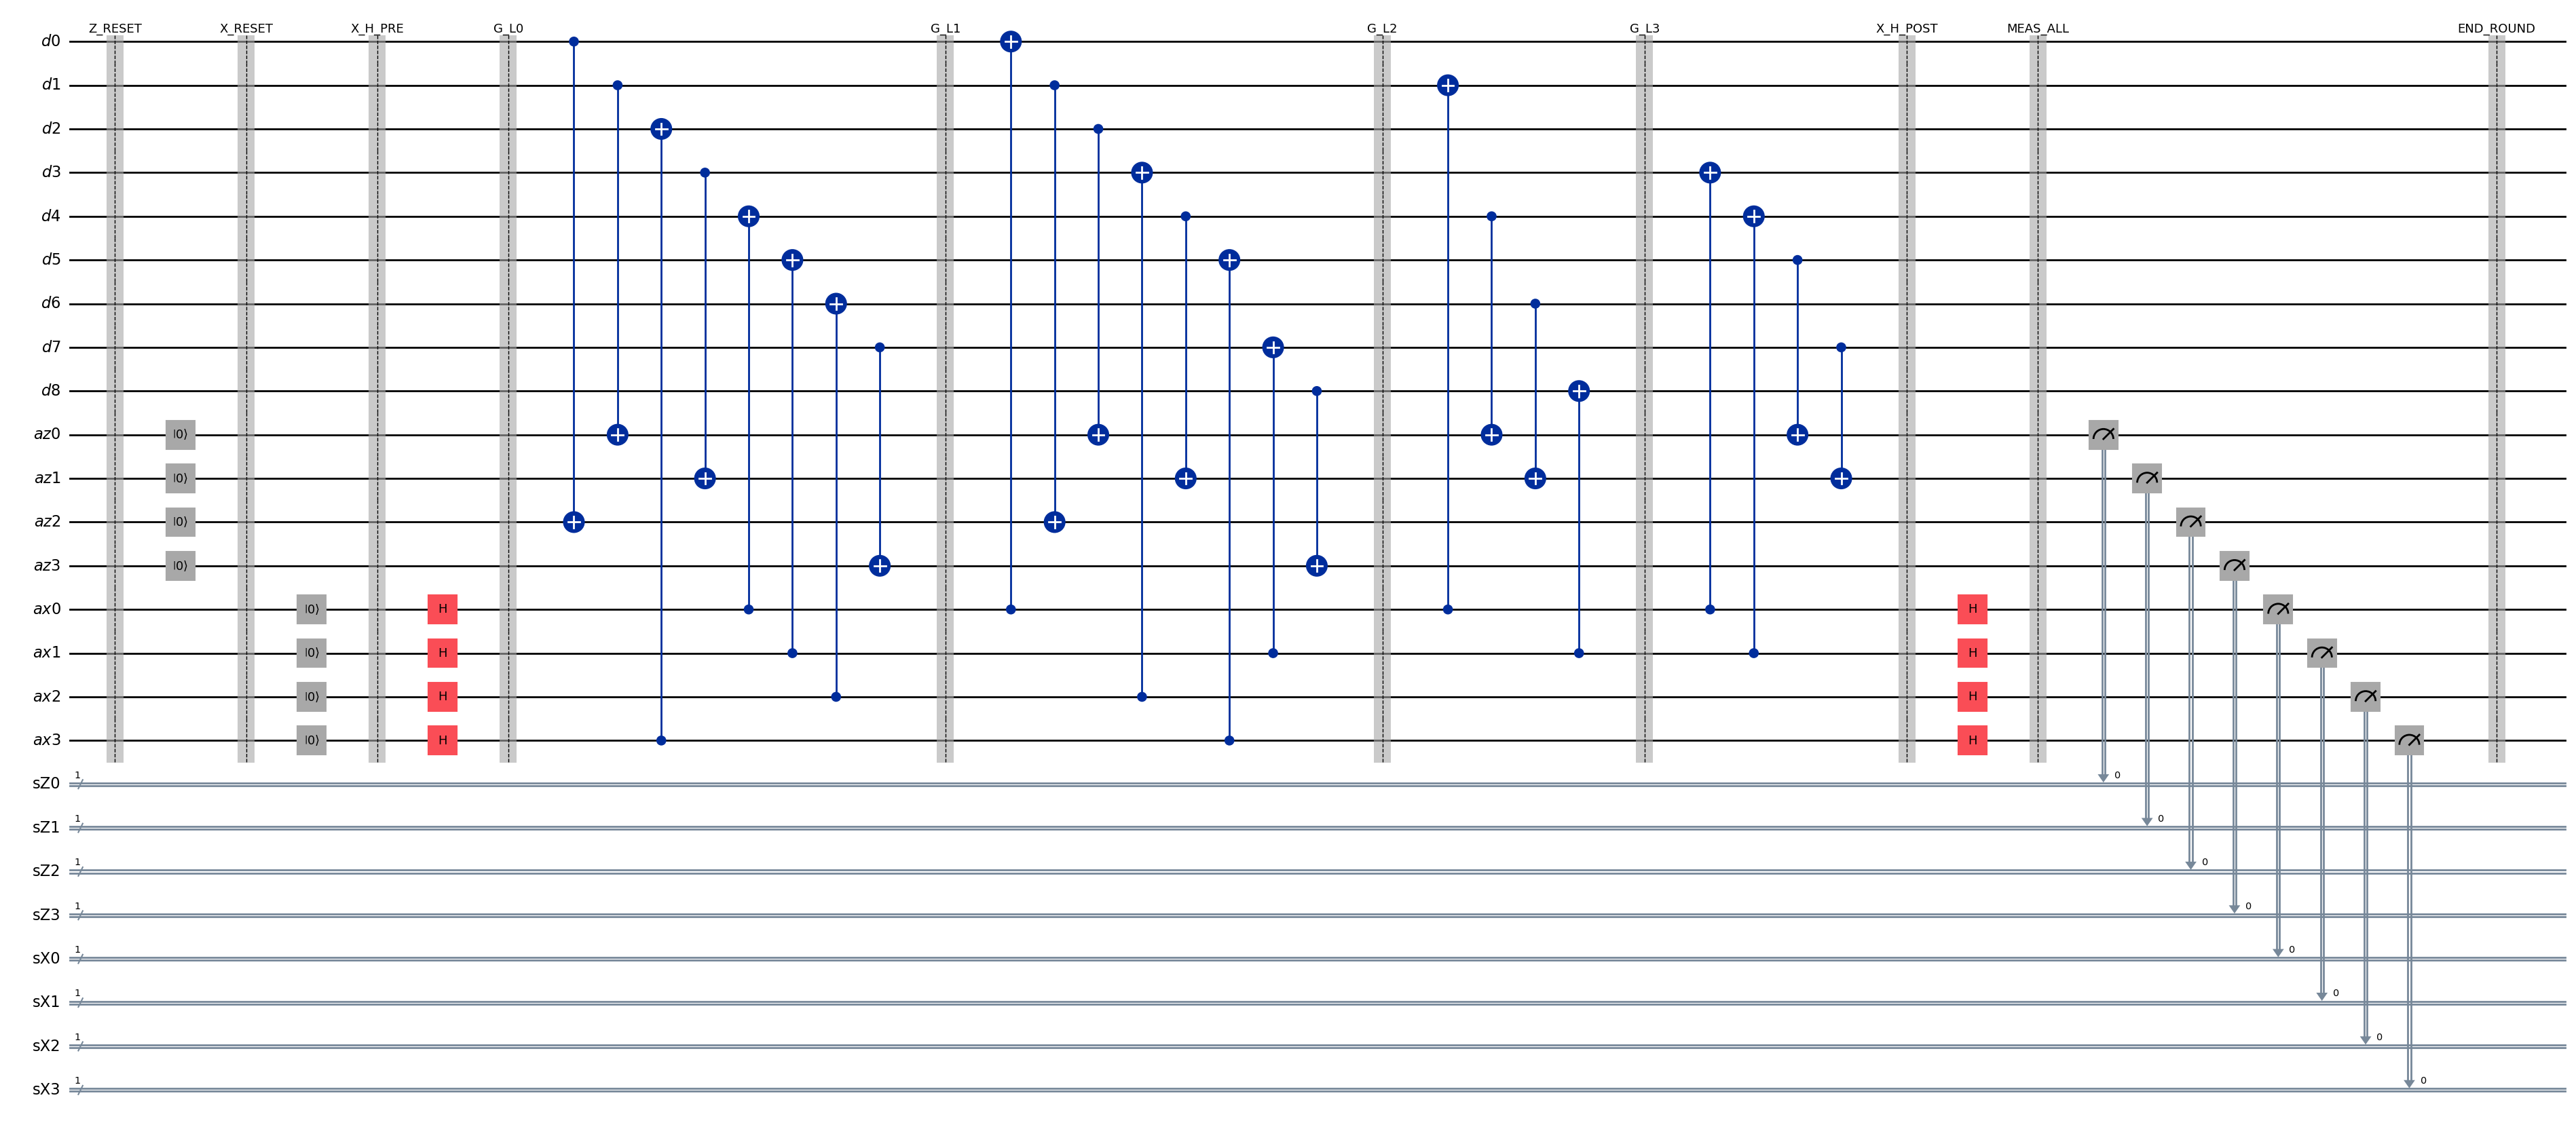

In [16]:
from collections import defaultdict, deque
from qiskit import QuantumCircuit

def _build_global_edges(Z_CHECKS, X_CHECKS):
    """
    返回全局边列表 edges，每条边是 dict：
      {
        "type": "Z" or "X",
        "anc": "az0"/... or "ax0"/...,
        "data": "d0"/...
      }
    """
    edges = []
    # Z edges: data -> az
    for stab in Z_CHECKS:
        anc = stab["anc"]
        for d in stab["data"]:
            edges.append({"type": "Z", "anc": anc, "data": d})

    # X edges: ax -> data
    for stab in X_CHECKS:
        anc = stab["anc"]
        for d in stab["data"]:
            edges.append({"type": "X", "anc": anc, "data": d})

    return edges

def _global_layers_mixed(edges, data_order=None, prefer="data"):
    """
    全局分层：每层可同时包含 Z-edge 和 X-edge。
    约束：同层内不能有任何 qubit 冲突（data/anc 都不能重复）。

    参数：
      - edges: list[dict] 由 _build_global_edges 给出
      - data_order: 用于“按数据比特优先扫描”的顺序（让你更像手工并行挑选）
      - prefer:
          "data": 每层尽量覆盖更多 data（你的诉求）
          "none": 简单贪心按 edges 顺序塞

    返回：
      layers: list[list[dict]]，每个 dict 是一条边
    """
    if data_order is None:
        # 默认 d0..d8
        data_order = [f"d{i}" for i in range(9)]

    remaining = edges[:]
    layers = []

    # 为了“按 data 优先”，建立 data->候选边队列
    if prefer == "data":
        by_data = defaultdict(list)
        for e in remaining:
            by_data[e["data"]].append(e)
        # 每个 data 内部的边顺序保持原始（你也可以自定义排序策略）
        for d in by_data:
            by_data[d] = deque(by_data[d])

        # 记录未放置边数量
        total_left = len(remaining)

        while total_left > 0:
            used = set()     # 本层已经占用的 qubit 名（d* / ax* / az*）
            layer = []

            # 这一层：每个 data 尽量放 1 条边；如可行再尝试放同一 data 的第2条边会造成 data 冲突，所以不做
            for d in data_order:
                if not by_data[d]:
                    continue

                # 在该 data 的候选边里找一个 anc 未被占用的
                chosen_idx = None
                for i, e in enumerate(by_data[d]):
                    anc = e["anc"]
                    if (d not in used) and (anc not in used):
                        chosen_idx = i
                        break

                if chosen_idx is None:
                    continue

                # 取出该边
                tmp = list(by_data[d])
                e = tmp.pop(chosen_idx)
                by_data[d] = deque(tmp)

                layer.append(e)
                used.add(d)
                used.add(e["anc"])
                total_left -= 1

            if not layer:
                # 如果出现卡死，退化为“按剩余边顺序再塞一层”
                used = set()
                layer = []
                new_remaining = []
                for e in remaining:
                    d, anc = e["data"], e["anc"]
                    if d in used or anc in used:
                        new_remaining.append(e)
                    else:
                        layer.append(e)
                        used.add(d); used.add(anc)
                if not layer:
                    raise RuntimeError("Global scheduling stalled: cannot place any edge. Check edge set.")
                # 更新 remaining 与 by_data
                layers.append(layer)
                remaining = new_remaining
                by_data = defaultdict(deque)
                for e in remaining:
                    by_data[e["data"]].append(e)
                total_left = len(remaining)
                continue

            layers.append(layer)

            # 重建 remaining/by_data（简单可靠，规模很小不怕 O(n^2)）
            placed_set = set(id(e) for e in layer)
            new_remaining = []
            for e in remaining:
                if id(e) not in placed_set:
                    new_remaining.append(e)
            remaining = new_remaining

            by_data = defaultdict(deque)
            for e in remaining:
                by_data[e["data"]].append(e)

        return layers

    else:
        # prefer="none"：按 edges 顺序的简单贪心分层
        while remaining:
            used = set()
            layer = []
            new_remaining = []
            for e in remaining:
                d, anc = e["data"], e["anc"]
                if d in used or anc in used:
                    new_remaining.append(e)
                else:
                    layer.append(e)
                    used.add(d); used.add(anc)
            if not layer:
                raise RuntimeError("Global scheduling stalled: cannot place any edge. Check edge set.")
            layers.append(layer)
            remaining = new_remaining
        return layers
    
def build_one_round_hw_global_mixed(measure_both=True, prefer="data"):
    """
    全局分层（每层可混合 Z-edge & X-edge），测量统一到最后。
    - Z edges: cx(data -> az)
    - X edges: cx(ax -> data)
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Surface17_one_round_HW_GLOBAL_MIXED")

    DATA_ORDER = [f"d{i}" for i in range(9)]

    # ---- Reset Z anc ----
    qc.barrier(label="Z_RESET")
    for stab in Z_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    if not measure_both:
        # 只做 Z 的情况：就不用 X anc 了
        edges = _build_global_edges(Z_CHECKS, [])
        layers = _global_layers_mixed(edges, data_order=DATA_ORDER, prefer=prefer)
        for li, layer in enumerate(layers):
            qc.barrier(label=f"G_L{li}")
            for e in layer:
                d, az = e["data"], e["anc"]
                qc.cx(Q(qregs, d), Q(qregs, az))
        qc.barrier(label="MEAS_ALL")
        for i, stab in enumerate(Z_CHECKS):
            qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sZ{i}"))
        qc.barrier(label="END_ROUND")
        return qc

    # ---- Reset X anc + H_pre ----
    qc.barrier(label="X_RESET")
    for stab in X_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    qc.barrier(label="X_H_PRE")
    for stab in X_CHECKS:
        qc.h(Q(qregs, stab["anc"]))

    # ---- Global mixed layers ----
    edges = _build_global_edges(Z_CHECKS, X_CHECKS)
    layers = _global_layers_mixed(edges, data_order=DATA_ORDER, prefer=prefer)

    for li, layer in enumerate(layers):
        qc.barrier(label=f"G_L{li}")
        for e in layer:
            d = e["data"]
            anc = e["anc"]
            if e["type"] == "Z":
                qc.cx(Q(qregs, d), Q(qregs, anc))      # data -> az
            else:
                qc.cx(Q(qregs, anc), Q(qregs, d))      # ax -> data

    # ---- X_H_POST ----
    qc.barrier(label="X_H_POST")
    for stab in X_CHECKS:
        qc.h(Q(qregs, stab["anc"]))

    # ---- Measure all anc at the end ----
    qc.barrier(label="MEAS_ALL")
    for i, stab in enumerate(Z_CHECKS):
        qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sZ{i}"))
    for i, stab in enumerate(X_CHECKS):
        qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sX{i}"))

    qc.barrier(label="END_ROUND")
    return qc

qc_hw_global = build_one_round_hw_global_mixed(measure_both=True, prefer="data")
display(qc_hw_global.draw("mpl", fold=-1))

C:\Users\admin\AppData\Local\Temp\ipykernel_11680\1033449346.py:11: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


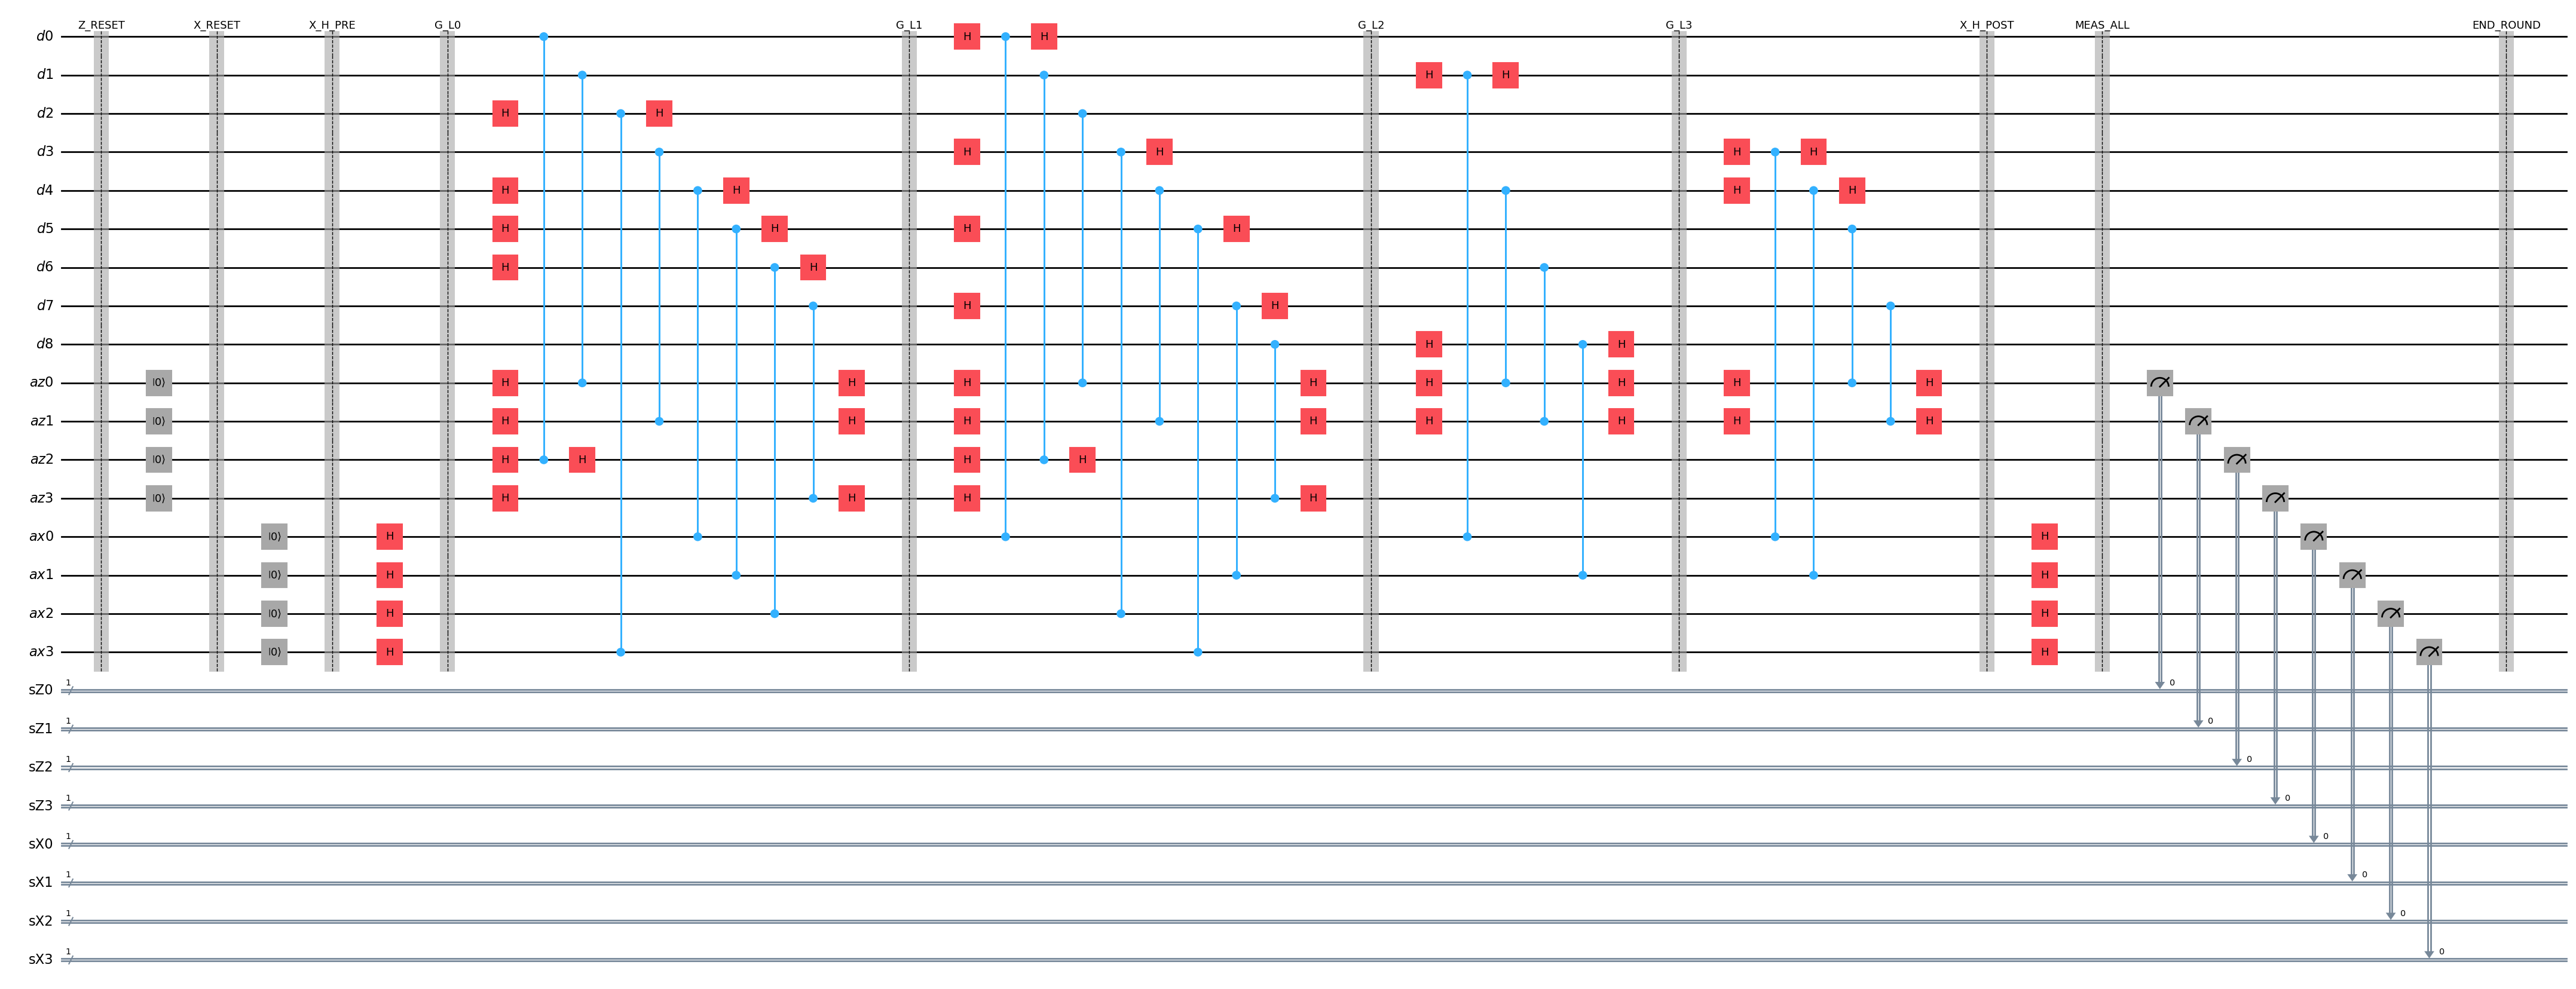

In [17]:
from qiskit import QuantumCircuit

def compile_cx_to_h_cz_keep_barriers(qc: QuantumCircuit) -> QuantumCircuit:
    """
    将电路中的所有 CX 编译为 H(target) - CZ - H(target)。
    - 保留 barrier（你的全局分层标签仍然可见）
    - 保留 reset/measure 等指令原样
    - 不调用 transpile（避免改变你手工/自定义调度后的时序结构）
    """
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_HCZ")
    for inst, qargs, cargs in qc.data:
        if inst.name in ("cx", "cnot"):
            ctrl, tgt = qargs[0], qargs[1]
            out.h(tgt)
            out.cz(ctrl, tgt)
            out.h(tgt)
        else:
            out.append(inst, qargs, cargs)
    return out

# 用法：qc_hw_global 是你截图里这个“global layered mixed”电路
qc_hcz = compile_cx_to_h_cz_keep_barriers(qc_hw_global)

display(qc_hcz.draw("mpl", fold=-1))


C:\Users\admin\AppData\Local\Temp\ipykernel_11680\1180866340.py:72: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:
C:\Users\admin\AppData\Local\Temp\ipykernel_11680\1180866340.py:62: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for j, (inst2, q2, c2) in enumerate(out.data):


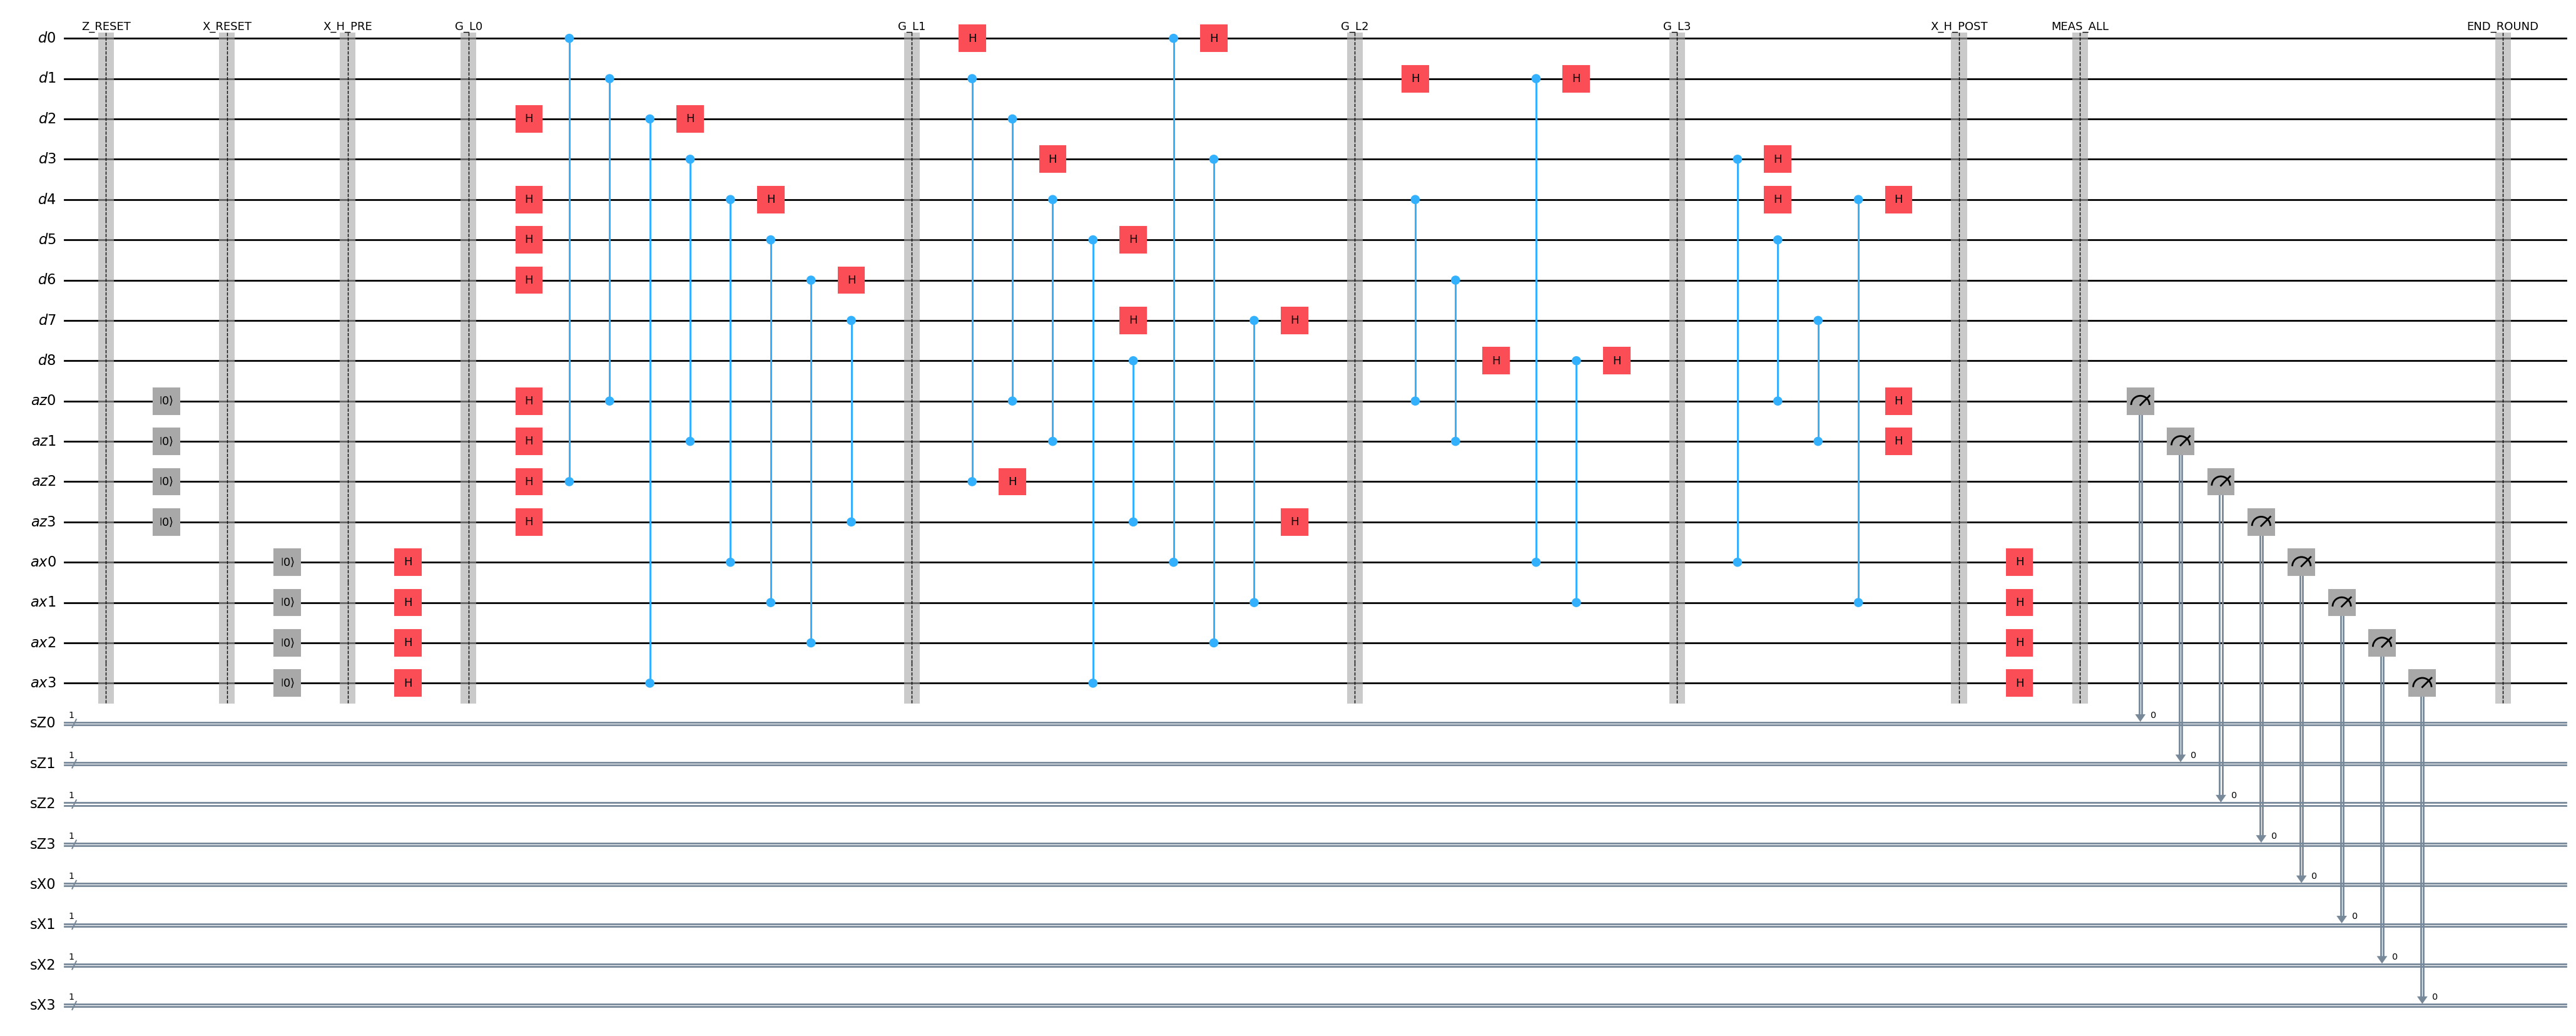

In [22]:
from qiskit import QuantumCircuit
from qiskit import QuantumCircuit

def cancel_H_pairs(qc: QuantumCircuit) -> QuantumCircuit:
    """
    消去同一比特线上可抵消的 H-H（H·H=I）。
    - 任何作用到该qubit的操作都会“打断”可合并性，包括 barrier
    - 不调用 transpile，不重排 CZ 等门
    """
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_Hcancel")

    # 记录每个 qubit 上最近一个“未匹配”的 H 在 out.data 中的位置
    last_H_idx = {}

    def rebuild_last_H_idx():
        """当 out.data 被 pop 后索引可能失效，重建 last_H_idx（规模小，直接重建最稳妥）"""
        last_H_idx.clear()
        for j, (inst2, q2, c2) in enumerate(out.data):
            if inst2.name == "h":
                last_H_idx[q2[0]] = j
            else:
                # 任何非H门都打断其作用比特的 pending-H
                for qq in q2:
                    last_H_idx.pop(qq, None)

    for inst, qargs, cargs in qc.data:
        if inst.name == "h":
            q = qargs[0]
            if q in last_H_idx:
                # 抵消：删除之前那个H，不再追加当前H
                out.data.pop(last_H_idx[q])
                rebuild_last_H_idx()
            else:
                out.h(q)
                last_H_idx[q] = len(out.data) - 1
            continue

        # 其他指令原样写入
        out.append(inst, qargs, cargs)

        # 该指令作用到的所有 qubit 都会打断 pending-H
        for q in qargs:
            last_H_idx.pop(q, None)

        # barrier 也会打断所有参与 qubit 的 pending-H（qargs 已覆盖）
        # measure/reset/cz 等同理

    return out


def cancel_H_pairs_allow_across_barrier(qc: QuantumCircuit) -> QuantumCircuit:
    """
    消去同一比特线上可抵消的 H-H（H·H=I）。
    - barrier 不打断（允许跨 barrier 合并 H）
    - 其他门（cz/reset/measure等）仍然打断
    """
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_Hcancel_nobarrierbreak")
    last_H_idx = {}

    def rebuild_last_H_idx():
        last_H_idx.clear()
        for j, (inst2, q2, c2) in enumerate(out.data):
            if inst2.name == "h":
                last_H_idx[q2[0]] = j
            elif inst2.name == "barrier":
                # 不打断
                pass
            else:
                for qq in q2:
                    last_H_idx.pop(qq, None)

    for inst, qargs, cargs in qc.data:
        if inst.name == "h":
            q = qargs[0]
            if q in last_H_idx:
                out.data.pop(last_H_idx[q])
                rebuild_last_H_idx()
            else:
                out.h(q)
                last_H_idx[q] = len(out.data) - 1
            continue

        out.append(inst, qargs, cargs)

        if inst.name != "barrier":
            for q in qargs:
                last_H_idx.pop(q, None)

    return out
from qiskit import QuantumCircuit

def remove_barriers(qc: QuantumCircuit) -> QuantumCircuit:
    out = QuantumCircuit(*qc.qregs, *qc.cregs, name=f"{qc.name}_nobarrier")
    for inst, qargs, cargs in qc.data:
        if inst.name == "barrier":
            continue
        out.append(inst, qargs, cargs)
    return out


qc_hcz_opt = cancel_H_pairs_allow_across_barrier(qc_hcz)
display(qc_hcz_opt.draw("mpl", fold=-1))



C:\Users\admin\AppData\Local\Temp\ipykernel_11680\1033449346.py:11: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for inst, qargs, cargs in qc.data:


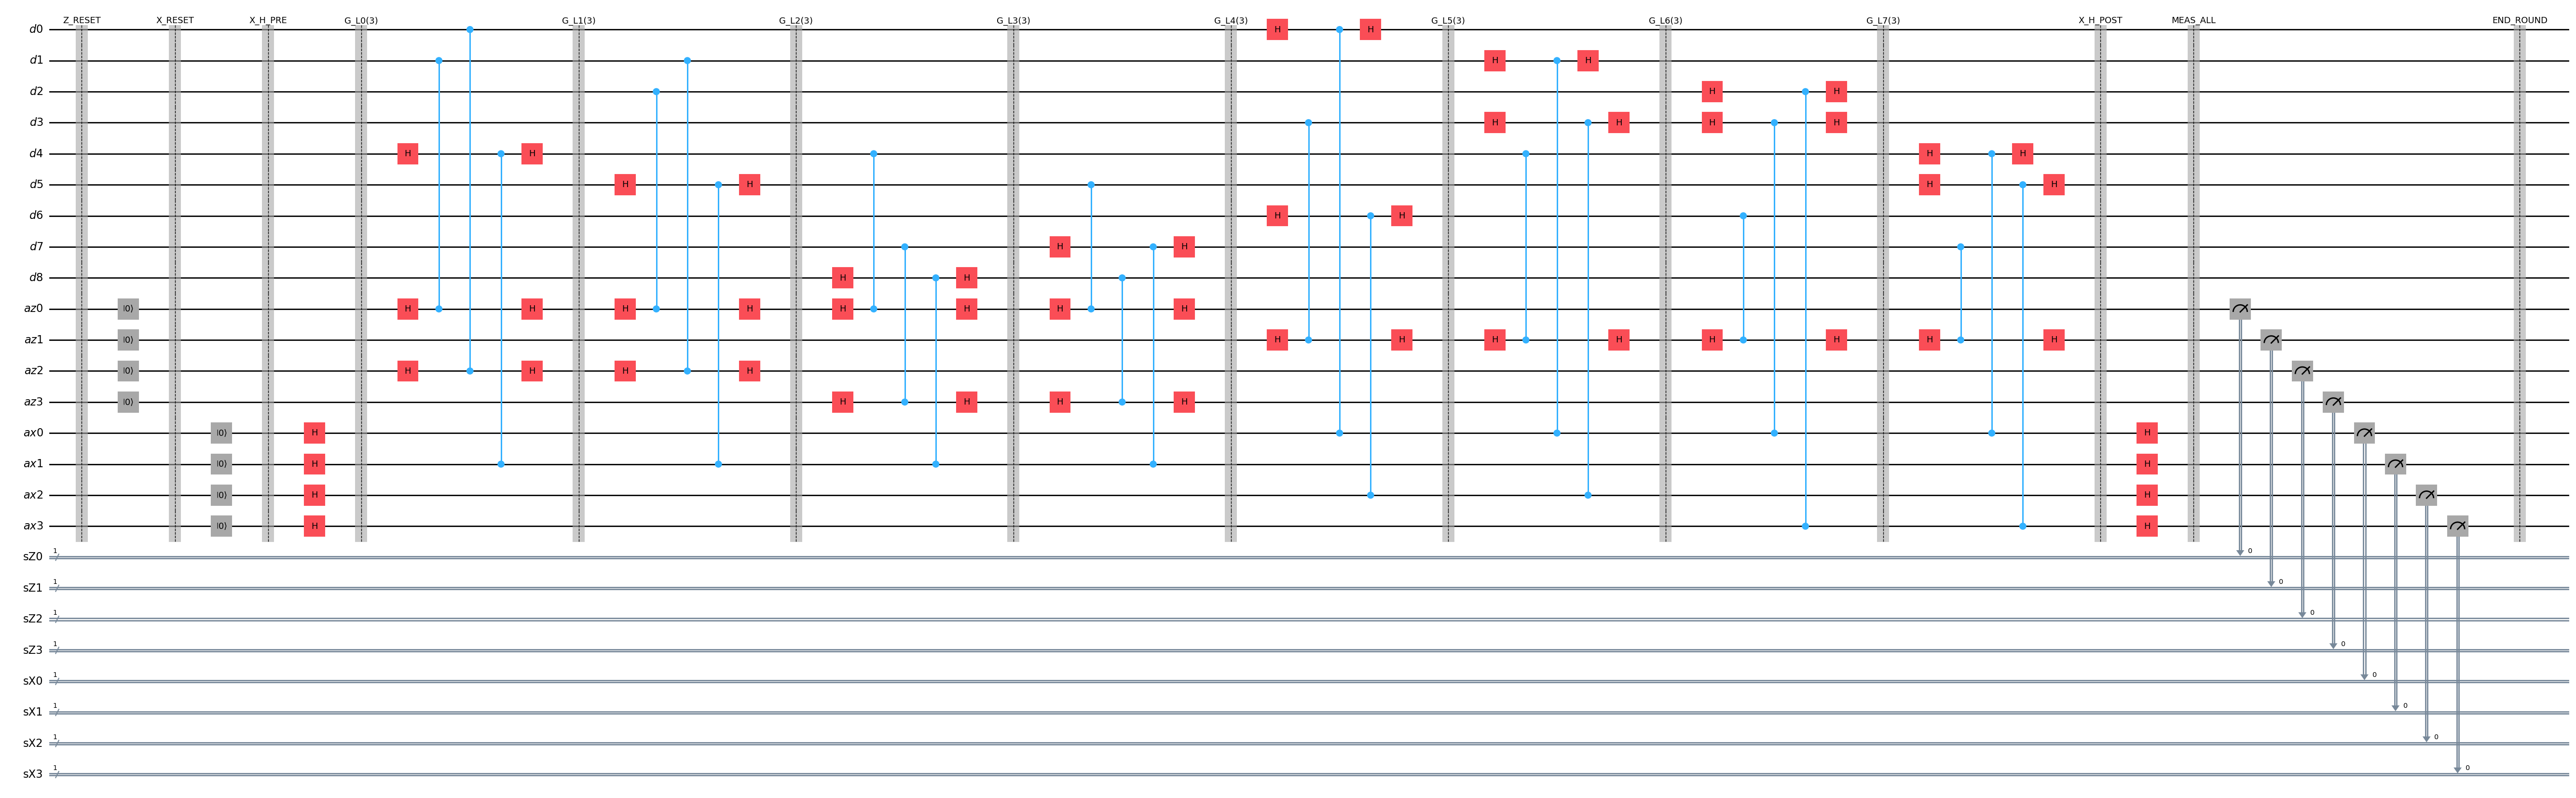

In [28]:
from collections import defaultdict
from qiskit import QuantumCircuit

def build_global_edges(Z_CHECKS, X_CHECKS):
    edges = []
    for stab in Z_CHECKS:
        anc = stab["anc"]
        for d in stab["data"]:
            edges.append({"type": "Z", "anc": anc, "data": d})
    for stab in X_CHECKS:
        anc = stab["anc"]
        for d in stab["data"]:
            edges.append({"type": "X", "anc": anc, "data": d})
    return edges

def balanced_layers(edges, K, edge_order=None):
    """
    把 edges 分配到 K 个层里，使每层数量尽量均匀，同时保证同层无 qubit 冲突。
    冲突约束：同层不能重复使用 data 或 anc（等价于 matching）。
    """
    if edge_order is None:
        edge_order = edges  # 使用原始顺序
    else:
        edge_order = edge_order(edges)

    layers = [[] for _ in range(K)]
    used = [set() for _ in range(K)]   # 每层占用的 qubit 名（d*/ax*/az*）
    load = [0]*K

    for e in edge_order:
        d, a = e["data"], e["anc"]

        # 按当前负载从小到大尝试放置
        idxs = sorted(range(K), key=lambda i: load[i])
        placed = False
        for i in idxs:
            if (d not in used[i]) and (a not in used[i]):
                layers[i].append(e)
                used[i].add(d); used[i].add(a)
                load[i] += 1
                placed = True
                break
        if not placed:
            raise RuntimeError(
                f"Cannot place edge {e} into any of {K} layers. Increase K or change ordering."
            )

    return layers, load

def build_one_round_hw_global_mixed_balanced(measure_both=True, K=8):
    """
    全局分层（X/Z edge 同层允许）+ 负载均衡（每层边数接近）+ 测量在最后。
    K：你希望的“全局层数”（越大越容易均匀，但总层数也越多）。
    """
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name=f"Surface17_GLOBAL_BAL_K{K}")

    all_qubits = [q for qreg in qc.qregs for q in qreg]

    qc.barrier(label="Z_RESET")
    for stab in Z_CHECKS:
        qc.reset(Q(qregs, stab["anc"]))

    if measure_both:
        qc.barrier(label="X_RESET")
        for stab in X_CHECKS:
            qc.reset(Q(qregs, stab["anc"]))

        qc.barrier(label="X_H_PRE")
        for stab in X_CHECKS:
            qc.h(Q(qregs, stab["anc"]))

        edges = build_global_edges(Z_CHECKS, X_CHECKS)
        layers, load = balanced_layers(edges, K=K)

        for li, layer in enumerate(layers):
            qc.barrier(*all_qubits, label=f"G_L{li}({load[li]})")
            for e in layer:
                d, anc = e["data"], e["anc"]
                if e["type"] == "Z":
                    qc.cx(Q(qregs, d), Q(qregs, anc))   # data -> az
                else:
                    qc.cx(Q(qregs, anc), Q(qregs, d))   # ax -> data

        qc.barrier(label="X_H_POST")
        for stab in X_CHECKS:
            qc.h(Q(qregs, stab["anc"]))

        qc.barrier(label="MEAS_ALL")
        for i, stab in enumerate(Z_CHECKS):
            qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sZ{i}"))
        for i, stab in enumerate(X_CHECKS):
            qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sX{i}"))

    else:
        edges = build_global_edges(Z_CHECKS, [])
        layers, load = balanced_layers(edges, K=K)
        for li, layer in enumerate(layers):
            qc.barrier(*all_qubits, label=f"G_L{li}({load[li]})")
            for e in layer:
                qc.cx(Q(qregs, e["data"]), Q(qregs, e["anc"]))
        qc.barrier(label="MEAS_ALL")
        for i, stab in enumerate(Z_CHECKS):
            qc.measure(Q(qregs, stab["anc"]), C(cregs, f"sZ{i}"))

    qc.barrier(label="END_ROUND")
    return qc

qc_bal = build_one_round_hw_global_mixed_balanced(measure_both=True, K=8)
qc_bal_hcz = compile_cx_to_h_cz_keep_barriers(qc_bal)
display(qc_bal_hcz.draw("mpl", fold=-1))


## 5. 运行一次：返回综合征（8 个测量比特）

Qiskit `get_counts()` 的 key 往往带空格或按某种寄存器顺序拼接。为了稳定解析：
- 先把 key 中非 0/1 的字符全部去掉
- 然后取末尾 8 位（因为本电路总共 8 个 syndrome classical bits）
- 再按 `[sZ0,sZ1,sZ2,sZ3, sX0,sX1,sX2,sX3]` 切片

In [9]:
backend = AerSimulator()

def clean01(s: str) -> str:
    return re.sub(r'[^01]', '', s)

def run_once_get_key(qc):
    tqc = transpile(qc, backend, optimization_level=0)
    res = backend.run(tqc, shots=1).result()
    counts = res.get_counts()
    key = list(counts.keys())[0]
    return key, counts

def parse_syndrome_from_key(key: str):
    raw = key
    c = clean01(key)
    tail = c[-8:]  # last 8 bits are syndrome bits (by construction in this notebook)
    bits = [int(b) for b in tail]  # keep order as printed
    sZ = bits[0:4]
    sX = bits[4:8]
    return raw, tail, sZ, sX, bits

key0, counts0 = run_once_get_key(qc_round)
raw, tail, sZ, sX, bits = parse_syndrome_from_key(key0)

print("raw key:", raw)
# print("cleaned(last8):", tail)
# print("sZ (Z-check syndrome):", sZ)
# print("sX (X-check syndrome):", sX)
# print("counts:", counts0)

raw key: 0 0 0 0 0 0 0 0


## 6. 注入错误 → 综合征 → toy 解码 → 反馈纠错（并输出电路图）

### 重要提醒：为什么“错误在 d1，但纠正可能落在 d7”？
在 surface code（尤其是只做单轮、且 toy decoder 很粗糙的情况下），**同一个综合征对应的“纠错链”通常不唯一**：
- 只要纠错操作与真实错误的组合，等价于某个 stabilizer 或一条同伦等价的链，就能回到码空间。
- 因此，“纠正位置”不一定等于“真实出错位置”。工程上要用多轮 syndrome + 匹配解码（MWPM）来消除歧义。

这里我们先用 **单轮 toy decoder** 演示端到端流程：  
注入单比特 X/Z 错误 → 测量综合征 → 查表给出一个纠错建议 → 再测一轮验证综合征回到全 0。

In [10]:
def inject_error_then_round(err_type="X", err_data="d1", measure_both=True):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Inject_then_round")

    qc.barrier(label="INJECT")
    if err_type.upper() == "X":
        qc.x(Q(qregs, err_data))
    elif err_type.upper() == "Z":
        qc.z(Q(qregs, err_data))
    else:
        raise ValueError("err_type must be 'X' or 'Z'")

    qc.compose(build_one_round(measure_both=measure_both), inplace=True)
    return qc

# Build toy lookup (single-qubit) from stabilizer incidence
def build_single_X_lookup():
    # X error -> flips Z checks that include that data qubit
    lookup = {}
    for d in DATA:
        pattern = tuple(1 if d in stab["data"] else 0 for stab in Z_CHECKS)  # (sZ0..sZ3)
        lookup[pattern] = d
    return lookup

def build_single_Z_lookup():
    # Z error -> flips X checks that include that data qubit
    lookup = {}
    for d in DATA:
        pattern = tuple(1 if d in stab["data"] else 0 for stab in X_CHECKS)  # (sX0..sX3)
        lookup[pattern] = d
    return lookup

X_LOOKUP = build_single_X_lookup()
Z_LOOKUP = build_single_Z_lookup()

def toy_decode_single_X(sZ):
    return X_LOOKUP.get(tuple(sZ), None)

def toy_decode_single_Z(sX):
    return Z_LOOKUP.get(tuple(sX), None)

def feedback_then_round(correction=None, corr_type="X", measure_both=True):
    qregs = make_named_qubits()
    cregs = make_named_syndrome_bits()
    qc = QuantumCircuit(*qregs.values(), *cregs.values(), name="Feedback_then_round")

    qc.barrier(label="FEEDBACK")
    if correction is not None:
        if corr_type.upper() == "X":
            qc.x(Q(qregs, correction))
        elif corr_type.upper() == "Z":
            qc.z(Q(qregs, correction))
        else:
            raise ValueError("corr_type must be 'X' or 'Z'")
    qc.compose(build_one_round(measure_both=measure_both), inplace=True)
    return qc

### 6.1 示例：注入一个 X 错误（在 `d1`）

- X 错误会翻转与之反对易的 **Z stabilizer**（因此看 `sZ`）
- 用 `toy_decode_single_X(sZ)` 给出一个“单错假设”的纠错 qubit
- 反馈施加 X 纠正，再跑一轮，观察 syndrome 是否回到 0

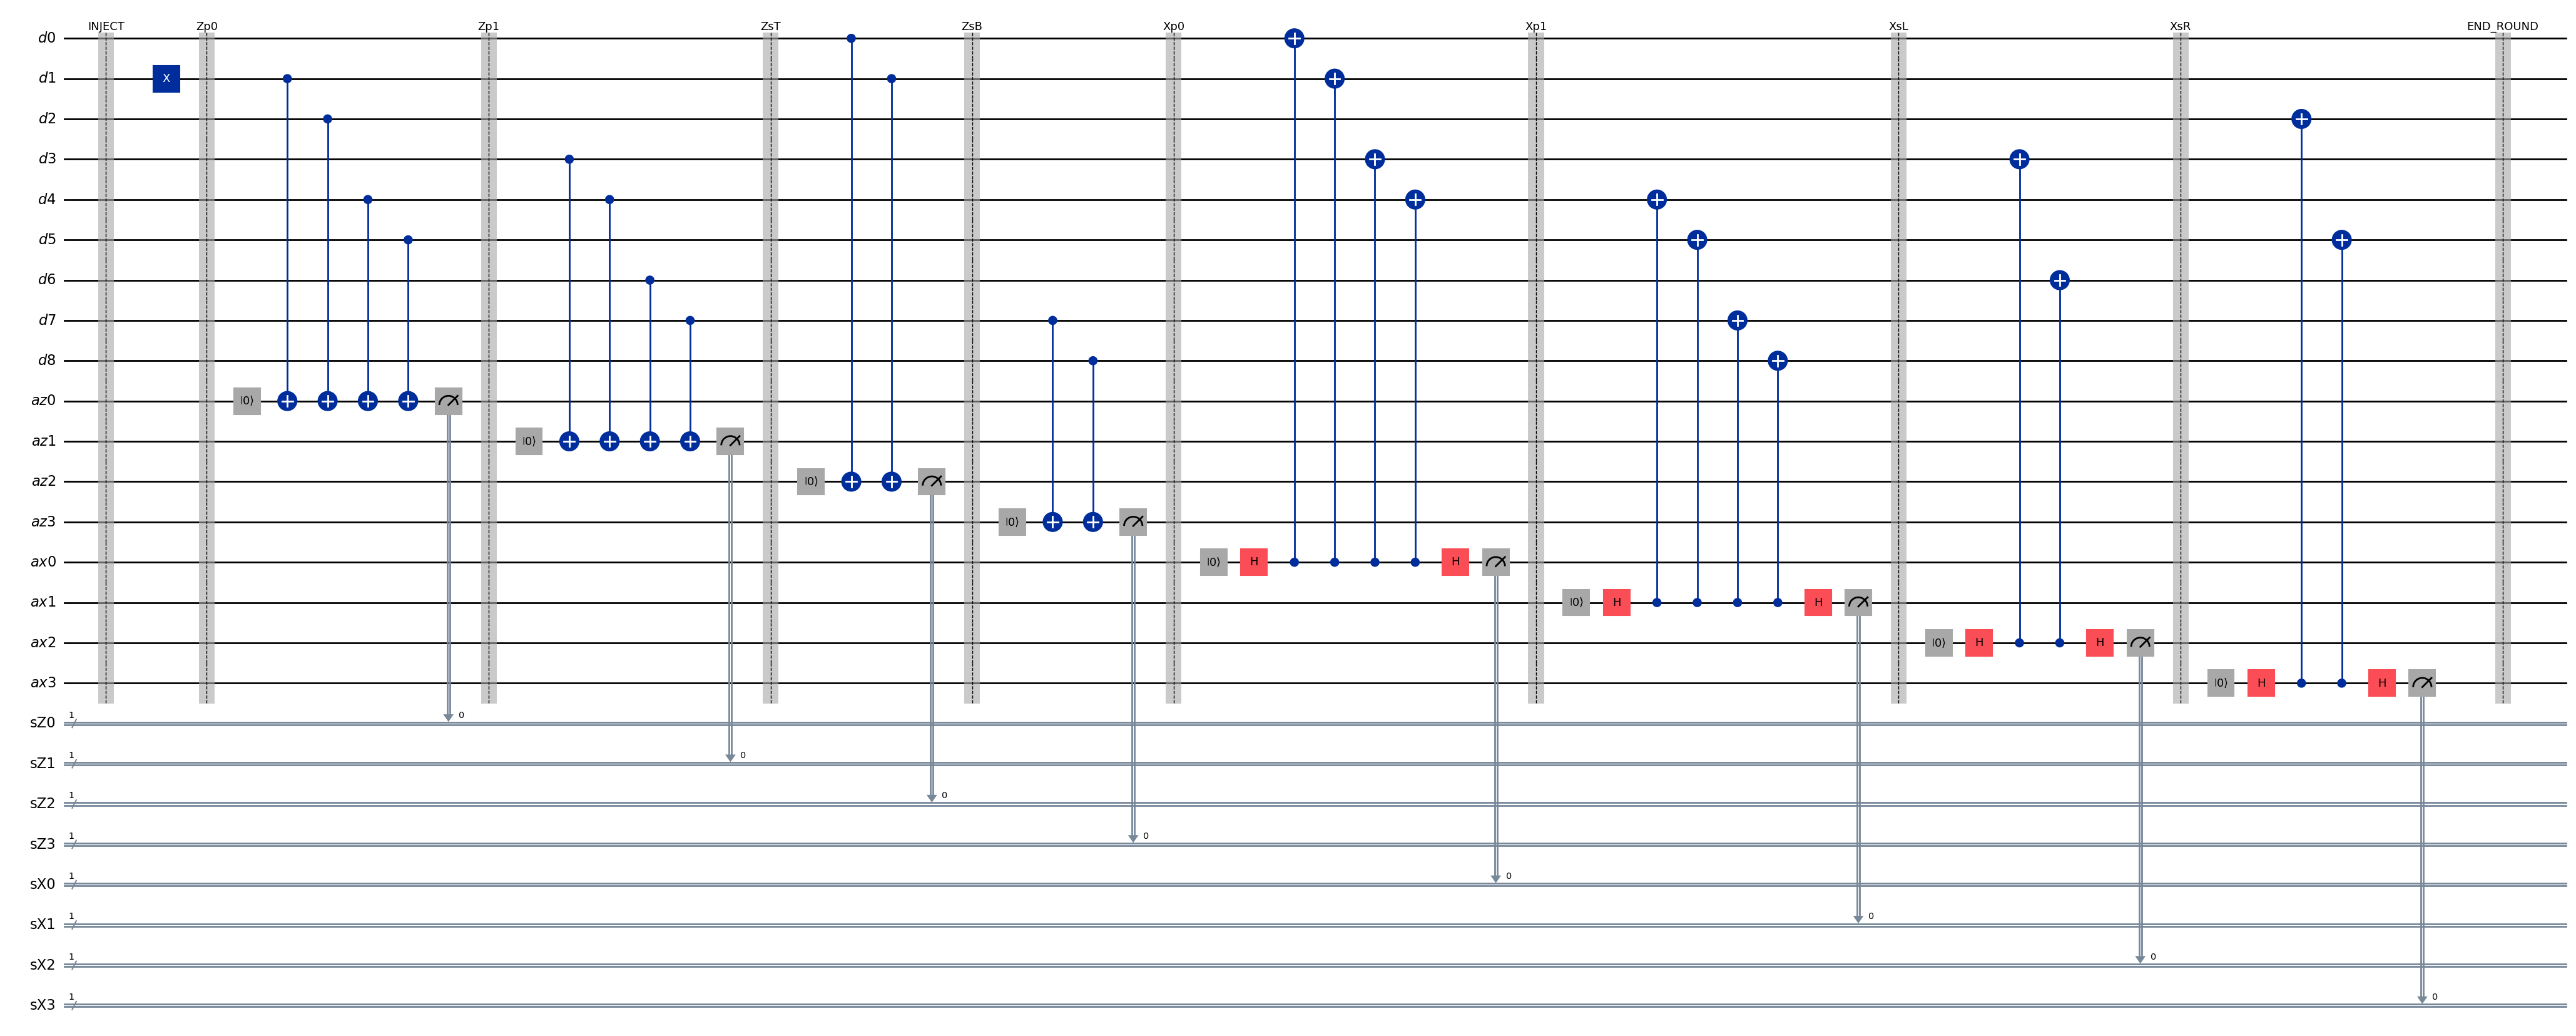

Round-1 counts: {'1 1 0 0 0 1 0 1': 1}
Round-1 sZ: [1, 1, 0, 0] (Z-check syndrome; X errors flip these)
Round-1 sX: [0, 1, 0, 1] (X-check syndrome; Z errors flip these)
Toy decoder guess (single-X): d4


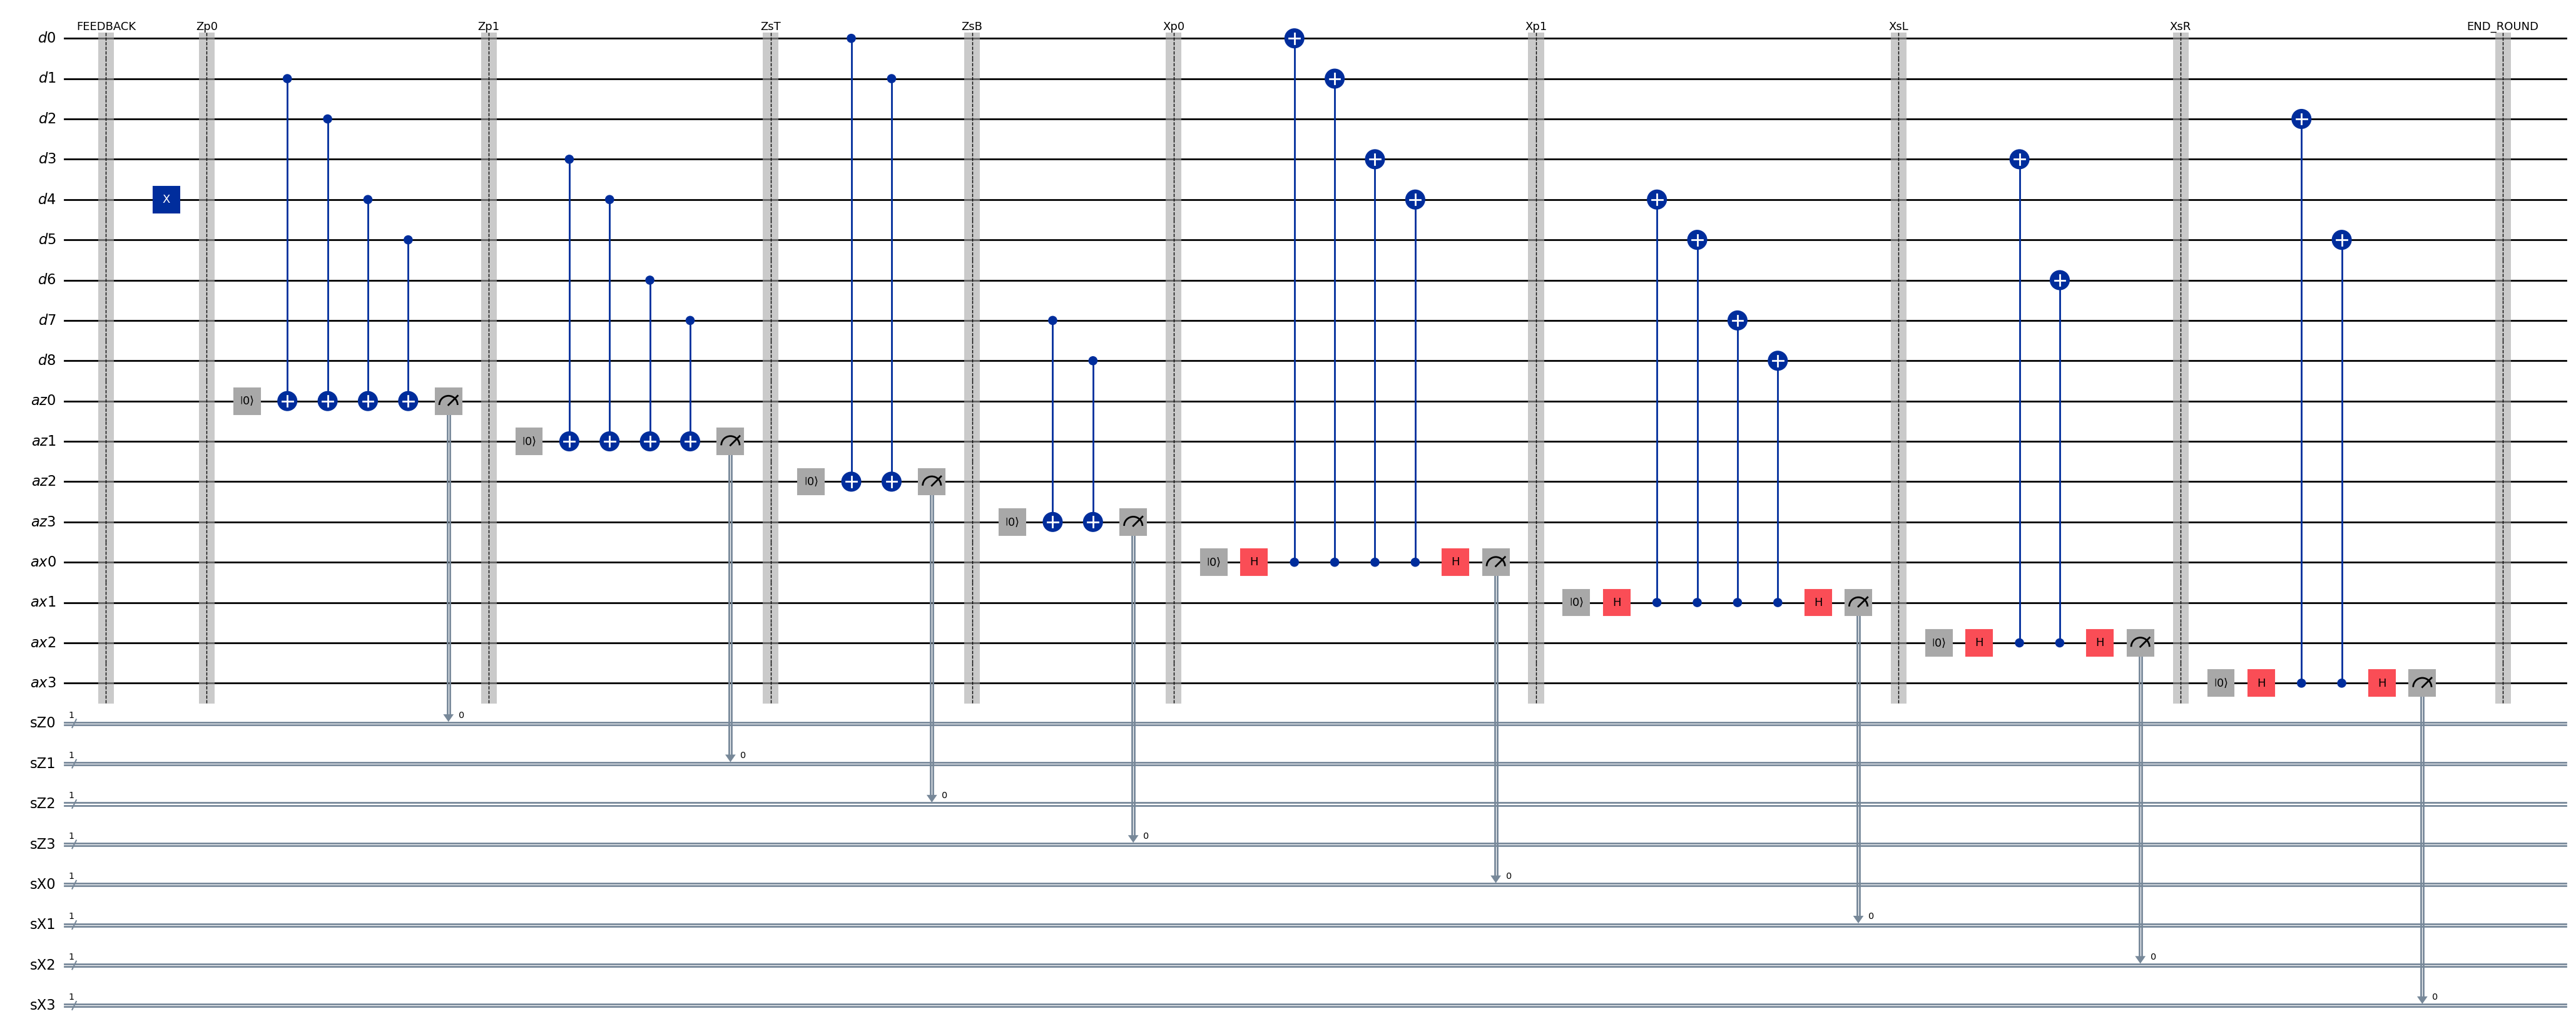

Round-2 counts: {'0 1 1 1 0 0 1 1': 1}
Round-2 sZ: [0, 1, 1, 1] sX: [0, 0, 1, 1]


In [11]:
# --- Example: inject X on d1 ---
qc_err = inject_error_then_round(err_type="X", err_data="d1", measure_both=True)
display(qc_err.draw("mpl", fold=-1))

key1, counts1 = run_once_get_key(qc_err)
raw1, tail1, sZ1, sX1, _ = parse_syndrome_from_key(key1)

print("Round-1 counts:", counts1)
print("Round-1 sZ:", sZ1, "(Z-check syndrome; X errors flip these)")
print("Round-1 sX:", sX1, "(X-check syndrome; Z errors flip these)")

guess = toy_decode_single_X(sZ1)
print("Toy decoder guess (single-X):", guess)

qc_fb = feedback_then_round(correction=guess, corr_type="X", measure_both=True)
display(qc_fb.draw("mpl", fold=-1))

key2, counts2 = run_once_get_key(qc_fb)
raw2, tail2, sZ2, sX2, _ = parse_syndrome_from_key(key2)
print("Round-2 counts:", counts2)
print("Round-2 sZ:", sZ2, "sX:", sX2)

### 6.2 示例：注入一个 Z 错误（在 `d1`）

- Z 错误会翻转与之反对易的 **X stabilizer**（因此看 `sX`）
- 用 `toy_decode_single_Z(sX)` 给出纠错位置
- 反馈施加 Z 纠正，再跑一轮验证

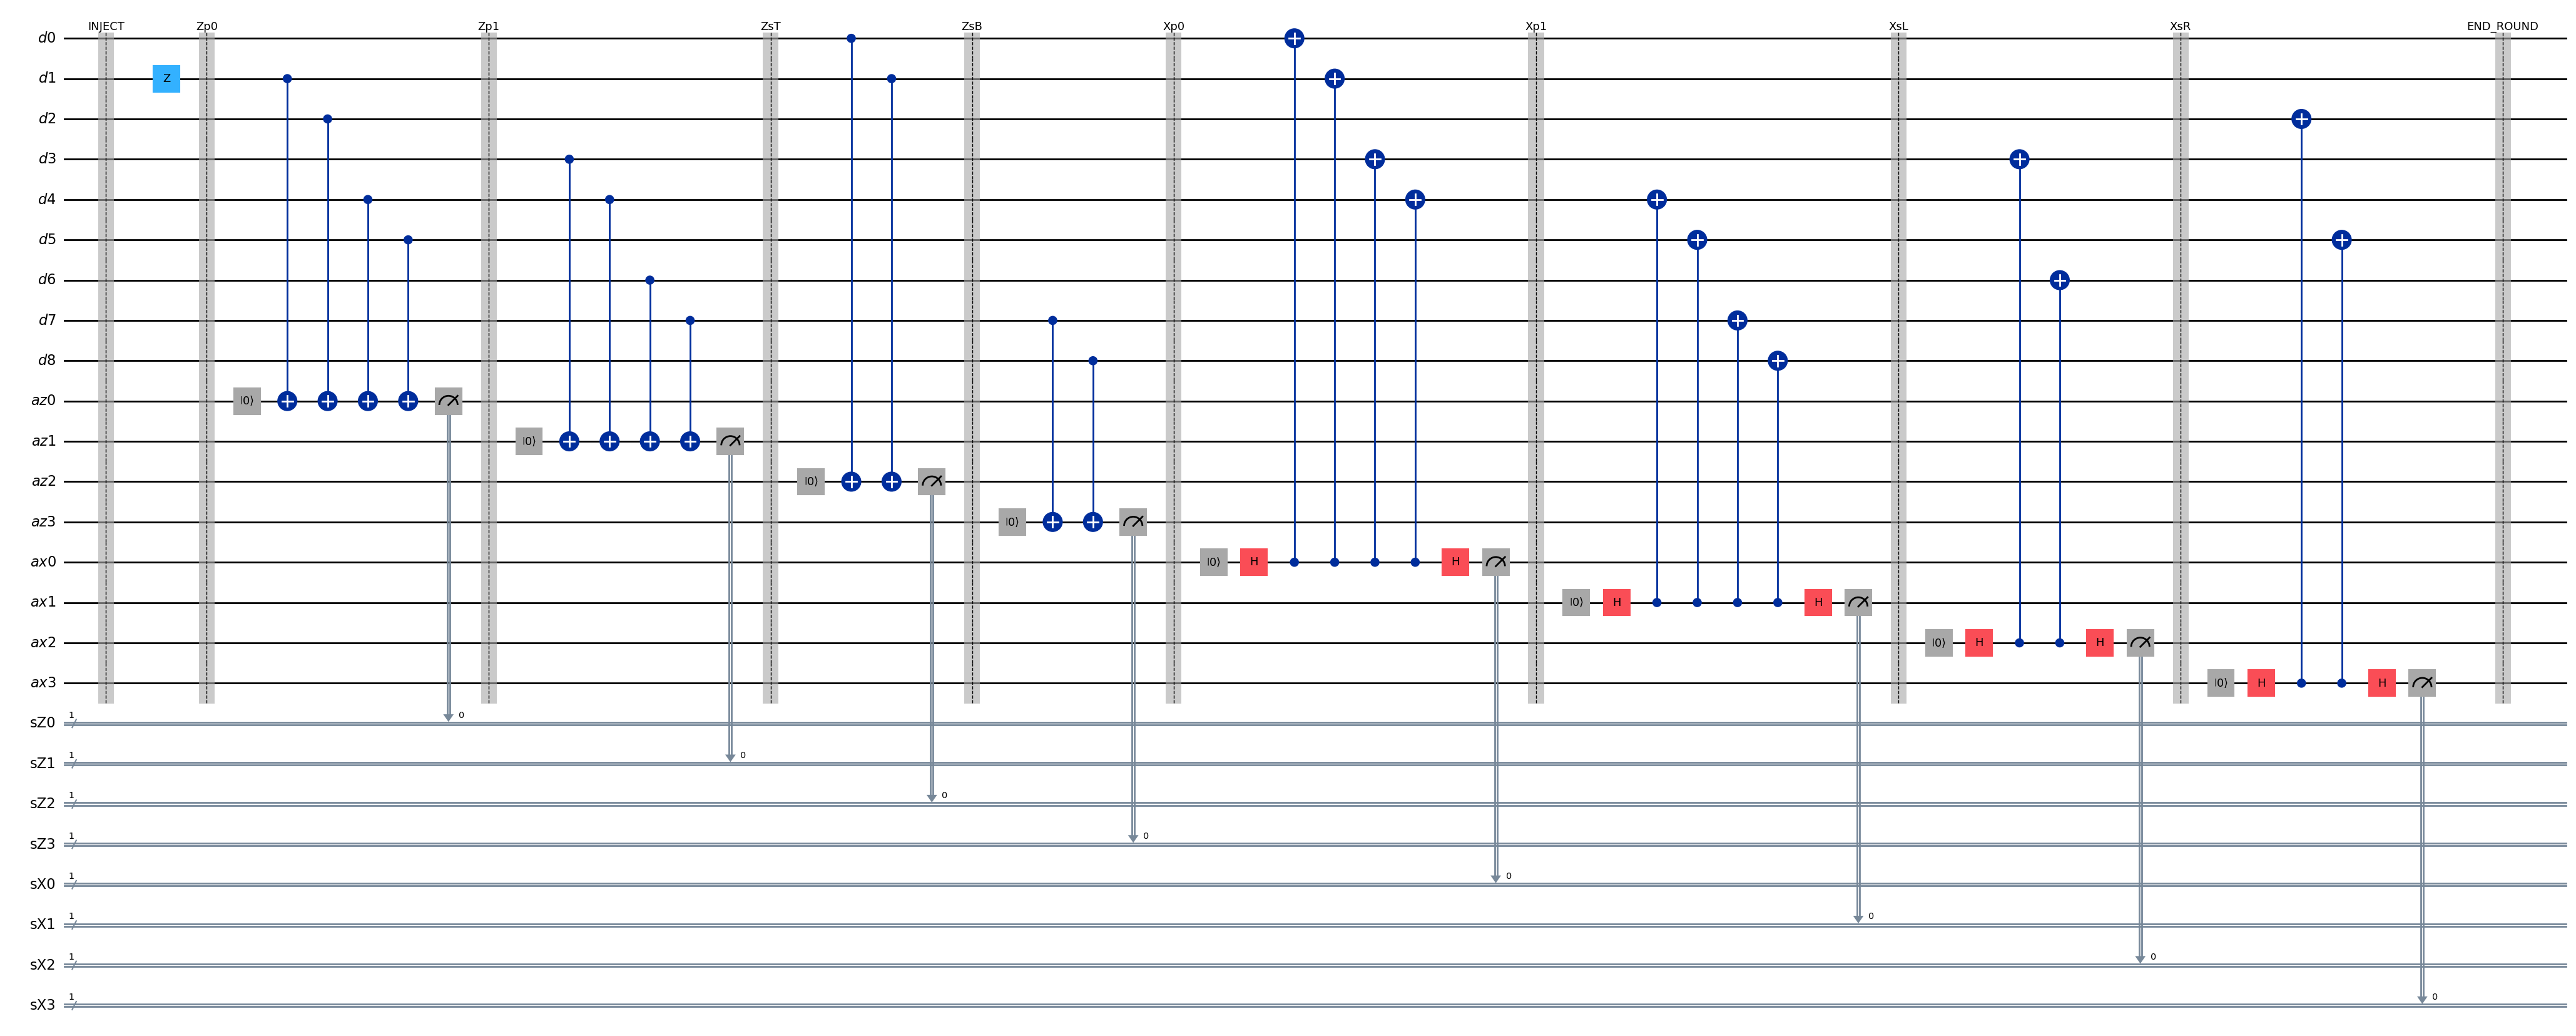

Round-1 counts: {'0 1 1 0 0 0 0 0': 1}
Round-1 sZ: [0, 1, 1, 0]
Round-1 sX: [0, 0, 0, 0] (X-check syndrome; Z errors flip these)
Toy decoder guess (single-Z): None


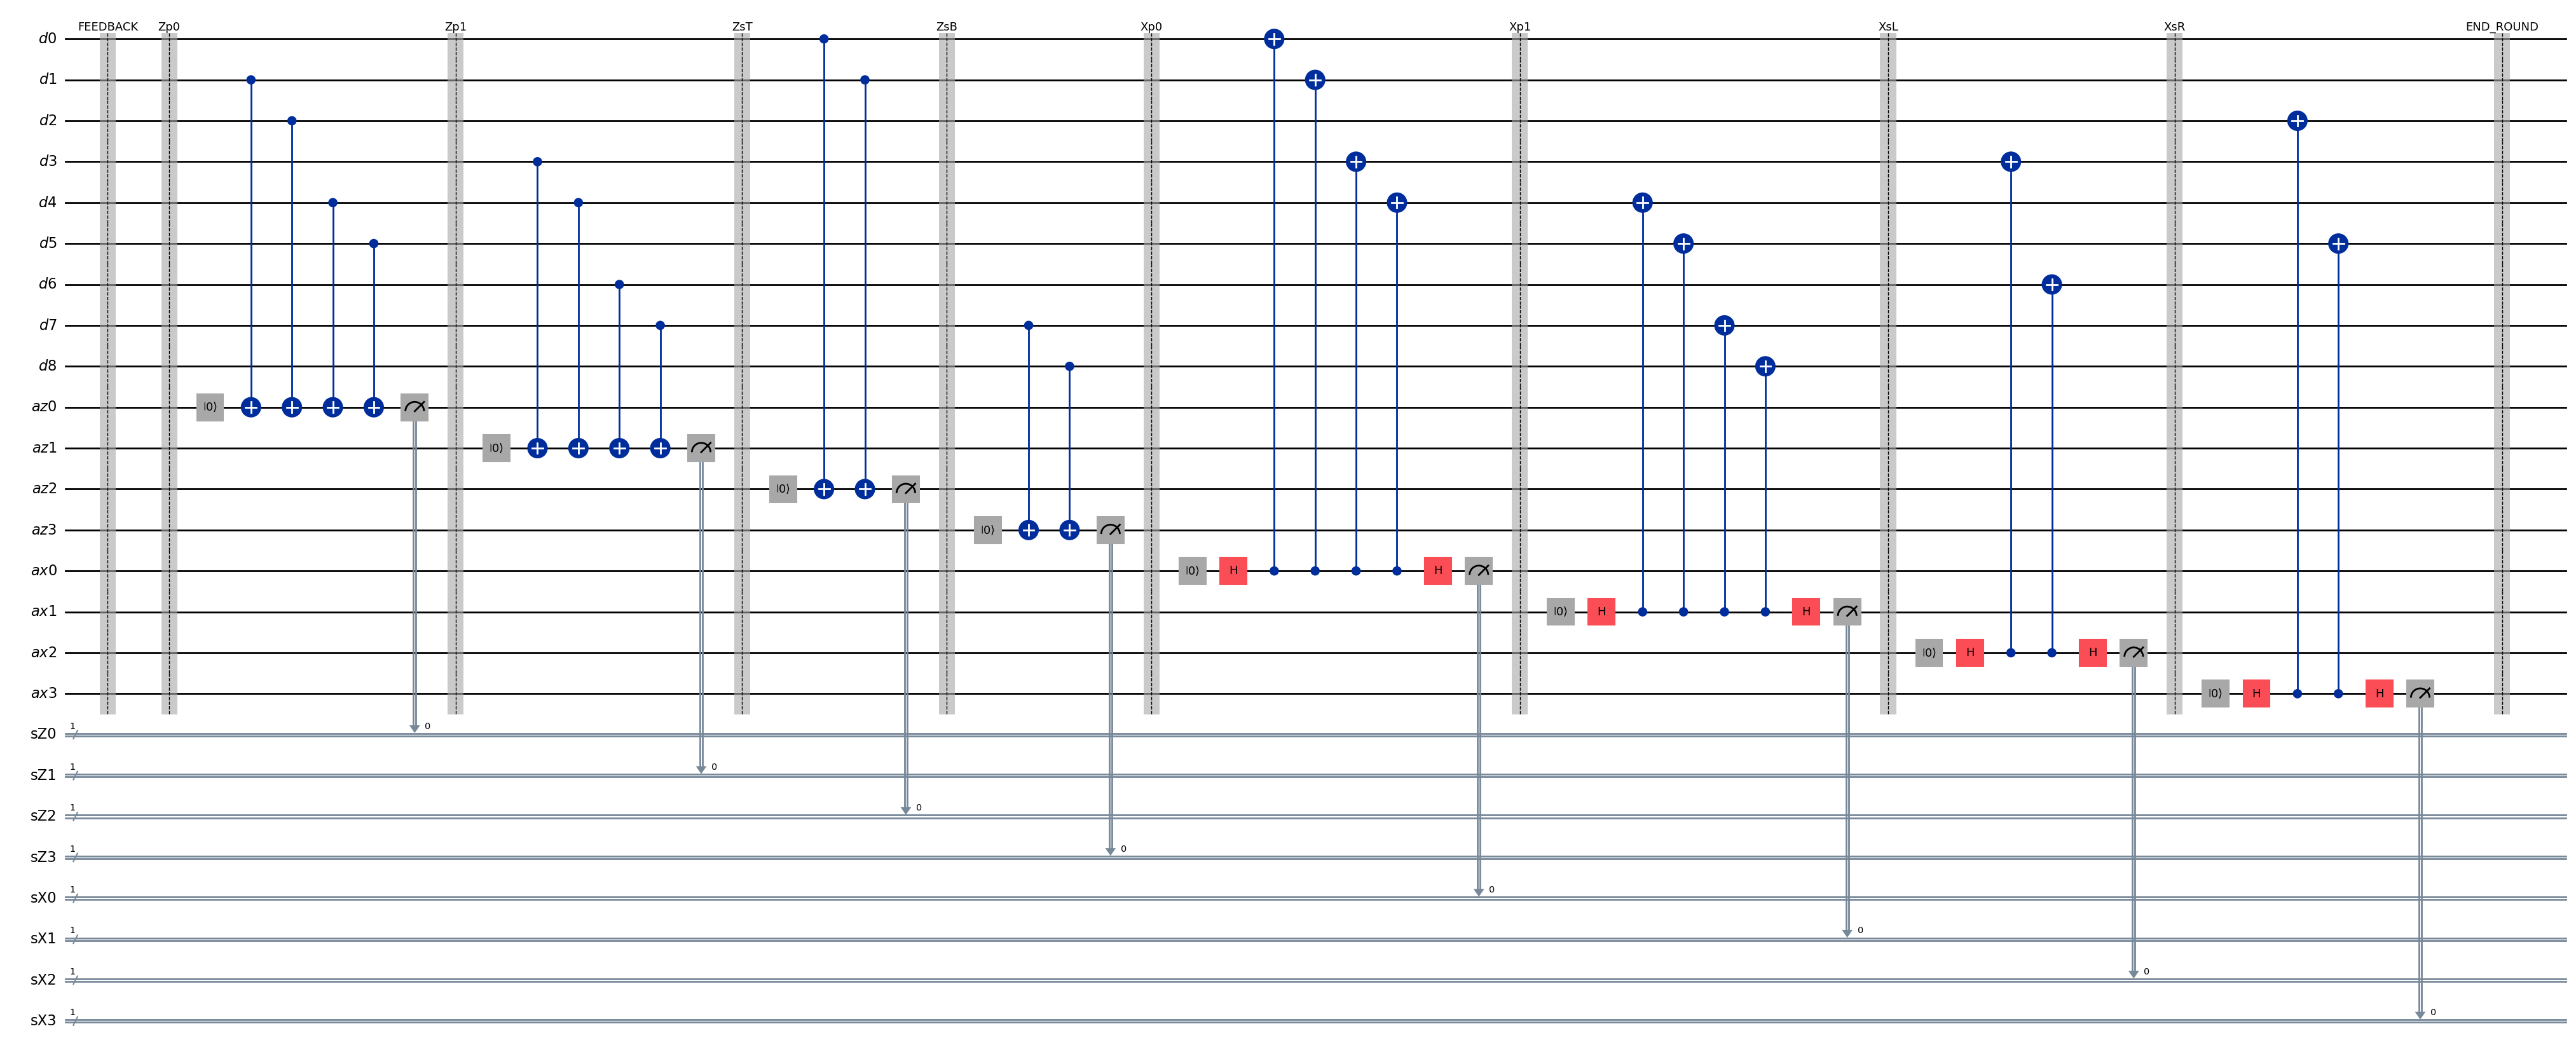

Round-2 counts: {'0 1 0 0 0 0 0 0': 1}
Round-2 sZ: [0, 1, 0, 0] sX: [0, 0, 0, 0]


In [12]:
# --- Example: inject Z on d1 ---
qc_errZ = inject_error_then_round(err_type="Z", err_data="d1", measure_both=True)
display(qc_errZ.draw("mpl", fold=-1))

key1z, counts1z = run_once_get_key(qc_errZ)
raw1z, tail1z, sZ1z, sX1z, _ = parse_syndrome_from_key(key1z)

print("Round-1 counts:", counts1z)
print("Round-1 sZ:", sZ1z)
print("Round-1 sX:", sX1z, "(X-check syndrome; Z errors flip these)")

guessZ = toy_decode_single_Z(sX1z)
print("Toy decoder guess (single-Z):", guessZ)

qc_fbZ = feedback_then_round(correction=guessZ, corr_type="Z", measure_both=True)
display(qc_fbZ.draw("mpl", fold=-1))

key2z, counts2z = run_once_get_key(qc_fbZ)
raw2z, tail2z, sZ2z, sX2z, _ = parse_syndrome_from_key(key2z)
print("Round-2 counts:", counts2z)
print("Round-2 sZ:", sZ2z, "sX:", sX2z)